# Extended offset + network LPM
Update Vs and rho later than vp + extend predicted initial rather than flip-copy + right flip also linear

In [1]:
import os
import sys
import copy
import glob
import numpy as np
import importlib
import multiprocessing

import segyio
from scipy import signal, ndimage
from natsort import natsorted
from skimage.transform import rescale, resize

import shared as sd
import loaders as ld
import vis

from IPython.display import clear_output

# remove the sys.path... line and add pyapi_denise.py to the same directory with the notebook
sys.path.append(os.path.abspath('../'))
import pyapi_denise as api
print(f'Python: {sys.prefix}')

Python: /home/ovcharoo/work/env_torch


In [2]:
# # This is to prevent error "this loop already runnign when doing magical %run <<notebook name>>"
import nest_asyncio
nest_asyncio.apply()

In [3]:
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable
# mpl.rcParams['figure.dpi']= 100
fontsize = 10
params = {
    # 'text.latex.preamble': ['\\usepackage{gensymb}'],
    # 'image.origin': 'lower',
    'image.interpolation': 'nearest',
    'figure.dpi' : 100,
    # 'image.cmap': 'gray',
    'axes.grid': False,
    'savefig.dpi': 150,  # to adjust notebook inline plot size
    'axes.labelsize':fontsize,  # fontsize for x and y labels (was 10)
    'axes.titlesize':fontsize,
    'font.size':fontsize,  # was 10
    'legend.fontsize': fontsize,  # was 10
    'xtick.labelsize':fontsize,
    'ytick.labelsize':fontsize,
    # 'text.usetex': True,
    # 'figure.figsize': [3.39, 2.10],
    'font.family': 'serif',
}
mpl.rcParams.update(params)

In [4]:
from ipynb.fs.defs.compare_ensembles_at_once import Wrapper, Ensemble, Blend
from ipynb.fs.defs.ibex_ccc_mix import Encoder, Head, HeadOld

root_fwi = './out_cgg_hard_log6_lpm_extended5/'
path_to_model1 = '/data/oleg/dump/paper_pear_lpm/'

# Init Denise API

In [5]:
importlib.reload(api)
denise_root = '../den/'
d = api.Denise(denise_root, verbose=1)

Init Python 3 API for Denise-Black-Edition.
Check binary in ../den/bin/denise
Parse ../den/par/DENISE_marm_OBC.inp
Current directory is /home/ovcharoo/work/nb12_pearson
Init paths at ./outputs/


In [6]:
# d.parser_report()

## Work directory
Where to output everything

In [7]:
d.save_folder = root_fwi
d.set_paths()

Current directory is /home/ovcharoo/work/nb12_pearson
Init paths at ./out_cgg_hard_log6_lpm_extended5/


# Get acquitision details

In [8]:
# shot_id_min = 60
# n_selected_shots = 80
# njump_src = 8
# shot_id_max = shot_id_min + (n_selected_shots-1) * njump_src

shot_id_min = 20
n_selected_shots = 85
njump_src = 8
shot_id_max = shot_id_min + (n_selected_shots-1) * njump_src


In [9]:
%run ./fwi_shared_check.ipynb

85/85
Before prep:	(85, 648, 3526)
Data cube:	(85, 324, 3000)
Extended cube:	(85, 324, 3100)
[85, 324, 3050] (85, 324, 3000)
[85, 324, 3150] (85, 324, 3100)
Assume even averacge spacing between sources
 150.0 m ~ 6 grid nodes
First source:	375.0 m
Last source:	12950.0 m
name:	
x	(85,):	min: 375.0	max: 12975.0
y	(85,):	min: 50.0	max: 50.0
wavelets:	None
z	(85,):	min: 0.0	max: 0.0
nshot:	85
td	(85,):	min: 0.0	max: 0.0
fc	(85,):	min: 8.0	max: 8.0
amp	(85,):	min: 1.0	max: 1.0
angle	(85,):	min: 0.0	max: 0.0
QUELLTYPB:	1
src_type	(85,):	min: 1.0	max: 1.0
drec:	25.0 m
x	(324,):	min: 525.0	max: 8600.0
y	(324,):	min: 100.0	max: 100.0
many:	[x	(324,):	min: 525.0	max: 8600.0
y	(324,):	min: 100.0	max: 100.0
name:	]


In [10]:
print('Field data spacing between sources {:.2f} m'.format(np.mean(src_.x[1:] - src_.x[:-1])))

Field data spacing between sources 149.78 m


In [11]:
vp_baseline = vp.copy()
print(vp.shape)

marm_path = os.path.join(root_fwi, 'start/')
os.makedirs(marm_path, exist_ok=True)
print(marm_path)
if not 'marmousi_II_marine.vp' in os.listdir(marm_path):
    # Download Marmousi II model
    os.system(f'wget https://github.com/daniel-koehn/DENISE-Benchmark/raw/master/Marmousi-II/start/marmousi_II_marine.vp -P {marm_path}')
    os.system(f'wget https://github.com/daniel-koehn/DENISE-Benchmark/raw/master/Marmousi-II/start/marmousi_II_marine.vs -P {marm_path}')
    os.system(f'wget https://github.com/daniel-koehn/DENISE-Benchmark/raw/master/Marmousi-II/start/marmousi_II_marine.rho -P {marm_path}')

    # Download initial model for FWI
    os.system(f'wget https://github.com/daniel-koehn/DENISE-Benchmark/raw/master/Marmousi-II/start/marmousi_II_start_1D.vp -P {marm_path}')
    os.system(f'wget https://github.com/daniel-koehn/DENISE-Benchmark/raw/master/Marmousi-II/start/marmousi_II_start_1D.vs -P {marm_path}')
    os.system(f'wget https://github.com/daniel-koehn/DENISE-Benchmark/raw/master/Marmousi-II/start/marmousi_II_start_1D.rho -P {marm_path}')
    
def get_vp_vs_rho(vp):
    vp = extend(vp, 15, 0)

    print(f'Reshape {vp.shape} into {wb_taper.shape}...')

    vp = resize(vp, wb_taper.shape, anti_aliasing=True)
    vp = np.where(vp <= 1500.0, 1490.0, vp)
    vp = extend(vp, 0, 264 + 10 * 8)

    # shear velocity, [m/s]
    vs = vp.copy() / (3 ** 0.5)
    vs = np.where(vp < 1.01 * np.min(vp), 0, vs)

    # density, [kg/m3] 
    rho = 1e3*0.3 * vp.copy()**0.25
    rho = np.where(vp < 1.01 * np.min(vp), 1000, rho)
    return vp, vs, rho

(152, 600)
./out_cgg_hard_log6_lpm_extended5/start/


In [12]:
# vp_marm = load_bin(f'{marm_path}marmousi_II_marine.vp', (500, 174))[:, 100:]
# print(vp_marm.min(), vp_marm.max())

# # This is what was used in generation of training data
# box_min = 1490.
# box_max = 4000. 

# vmin_marm = vp_marm.min()
# vp_marm -= vmin_marm

# vmax_marm = vp_marm.max()
# vp_marm /= vmax_marm
# vp_marm = box_min  + vp_marm * (box_max - box_min)
# print(vp_marm.min(), vp_marm.max())

In [13]:
# vp, vs, rho = get_vp_vs_rho(vp_marm)
# vis.plot_acquisition(vp, dx, src, rec, title='Vp')
# model = api.Model(vp, vs, rho, dx)
# print(model)

In [14]:
# vp_marm_linear = load_bin(f'{marm_path}marmousi_II_start_1D.vp', (500, 174))[:, 100:]
# vp_marm_linear -= vmin_marm
# vp_marm_linear /= vmax_marm
# vp_marm_linear = box_min  + vp_marm_linear * (box_max - box_min)

# vp_linear, vs_linear, rho_linear = get_vp_vs_rho(vp_marm_linear)
# vis.plot_acquisition(vp_linear, dx, src, rec, title='Vp')
# model_linear = api.Model(vp_linear, vs_linear, rho_linear, dx)

# log_linear = vp_linear[:, log_idx]
# print(model)

In [15]:
vp = extend(model.vp, 0, 264 + 10 * 8)
vp_long = vp.copy()
print(vp_long.shape)

(152, 944)


## Acquisition design

In [16]:
# Wavelet scaler to match field and synthetic
wavefield_amp_ratio = 77.08343437940496

vp:	(152, 600), 1490.0000, 2969.2560 m/s

vs:	(152, 600), 0.0000, 1714.3007 m/s

rho:	(152, 600), 1000.0000, 2214.5349 m/s

dx:	25.0000
Size:
	OX:	min 0.0000	max 14975.0000 m
Size:
	OZ:	min 0.0000	max 3775.0000 m


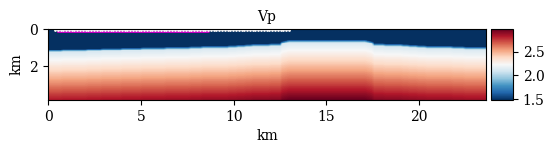

In [17]:
# Set custom wavelet
wls = bpw[:, ::2]
src.wavelets = wavefield_amp_ratio * wls[:, :limit_nt]

vis.plot_acquisition(vp, dx, src, rec, title='Vp')
print(model)

In [18]:
wb_taper = np.where(vp < 1.01 * vp.min(), 1, 0)

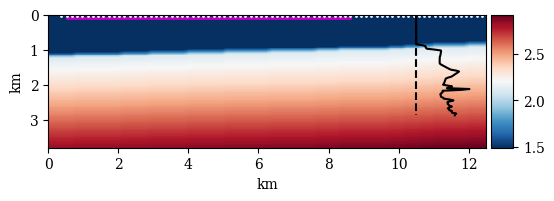

In [19]:
# log = model.vp[:, log_idx]
log = model.vp[-len(wlog):, log_idx]
# model_log = copy.deepcopy(model)

log_dict = {'data':wlog, 'loc': log_loc}
vis.plot_acquisition(vp[:, :500], dx, src, rec, log=log_dict)
# vis.savefig('vinit.png')

In [20]:
print(wb_taper.shape)

(152, 944)


(152, 944)
Well-log from 10500 maps into ix: 420


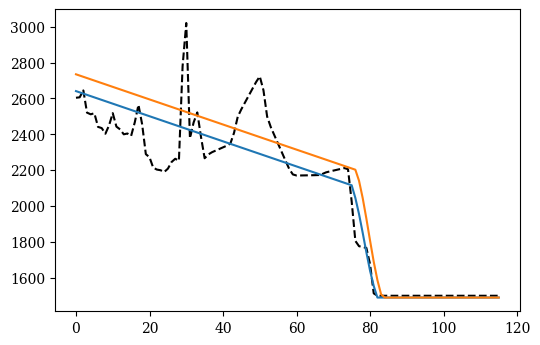

In [21]:
new_vp = np.zeros_like(model.vp)
vps=[]
for i in range(wb_taper.shape[-1]):
    wb = wb_taper.shape[0] - np.argmax(wb_taper[:,i]) + 2
    fun = vmin * np.ones_like(new_vp[:, 0:1])
    fun[wb:, :] = 690 + fun[wb:, :] + 7 * np.expand_dims(np.arange(len(fun[wb:, 0])), 1)
    fun = fun[::-1, :]
    vps.append(fun)
new_vp = np.concatenate(vps, -1)
new_vp = gaussian_filter(new_vp.copy(), **sigma_truncate)

print(new_vp.shape)
print(f'Well-log from {log_loc} maps into ix: {log_idx}')
plt.figure(); plt.plot(wlog, 'k--'); plt.plot(log[-len(wlog):]); plt.plot(new_vp[-len(wlog):, log_idx])

In [22]:
# num_pix = 10
# vps = []
# for i, wb in enumerate(wb_args):
#     the_log = new_vp[:, i:i+1].copy()
#     waterdepth=33
#     the_log[-wb-num_pix:-wb] = wlog[-waterdepth-num_pix:-waterdepth]
#     vps.append(the_log)
# vp_log = np.concatenate(vps, -1)
# print(vp_log.shape)

# vplog = vp_log[-len(wlog):, log_idx]

# vis.plot_acquisition(vp_log[:, :500], dx, src, rec, log=log_dict)

In [23]:
# fig, ax = plt.subplots(1,1); 
# ax_depth = np.arange(len(wlog)) * dx / 1000
# # ax_depth = np.arange(len(log)) * dx / 1000
# ax.plot(ax_depth, wlog[::-1] / 1000, 'b', label='CGG')
# ax.plot(ax_depth, log[::-1] / 1000, 'r', label='Linear')
# ax.plot(ax_depth, vplog[::-1] / 1000, 'r--', label='Better linear')
# # ax.plot(ax_depth, log_linear[::-1] / 1000, 'k--', label='Init')
# ax.set_ylabel('Velocity, km/s')
# ax.set_xlabel('Depth, km')

In [24]:
# print(wb_taper.shape, vp_cgg.shape, vp.shape)

In [25]:
vp = new_vp.copy()
vs = vp.copy() / (3 ** 0.5)
rho = 1e3*0.3 * vp.copy()**0.25

vp = np.where(wb_taper, np.min(vp_cgg), vp)
vs = np.where(wb_taper, 0, vs)
rho = np.where(wb_taper, 1000, rho)

# log = vplog.copy()
model = api.Model(vp, vs, rho, dx)

In [26]:
print(src, end='\n\n------------\n')
print(rec)

name:	
x	(85,):	min: 375.0	max: 12975.0
y	(85,):	min: 50.0	max: 50.0
wavelets	(85, 3000):	min: -400.8610078720592	max: 484.6122728113698
z	(85,):	min: 0.0	max: 0.0
nshot:	85
td	(85,):	min: 0.0	max: 0.0
fc	(85,):	min: 8.0	max: 8.0
amp	(85,):	min: 1.0	max: 1.0
angle	(85,):	min: 0.0	max: 0.0
QUELLTYPB:	1
src_type	(85,):	min: 1.0	max: 1.0

------------
x	(324,):	min: 525.0	max: 8600.0
y	(324,):	min: 100.0	max: 100.0
many:	[x	(324,):	min: 525.0	max: 8600.0
y	(324,):	min: 100.0	max: 100.0
name:	]


## Generate true waveforms

Set some runtime parameters which are different from defaults. Check defaults by runnning `help()`

In [27]:
# Elastic modeling
d.verbose = 1
d.PHYSICS = 1
d.SEISMO = 2
d.DT = dDT
d.NT = data_p.shape[-1]
d.TIME = dDT * d.NT
#
d.FC_SPIKE_2 = 10
d.REC_INCR_X = dsrc
d.N_STREAMER = len(rec)

# d.TESTSHOT_START = np.round(0.1 * len(src))
# d.TESTSHOT_END = np.round(0.9 * len(src))
# d.TESTSHOT_INCR = 5

d.TESTSHOT_START = 1
d.TESTSHOT_END = len(src)
d.TESTSHOT_INCR = 10

d.QUELLTYPB = 4
d.QUELLART = 3  

d.WRITE_STF = 0

# Acoustic case 
# d.PHYSICS = 2
# src.wavelets = -wls[:, :limit_nt]

print(d.DT, d.NT)

0.002 3000


### Run forward modeling

In [28]:
d.NPROCX = 1
d.NPROCY = 1
par_forward = {'run_command': 'mpirun -np 40', 'disable': False}

In [29]:
if not os.path.exists(d._root_su) or not os.listdir(d._root_su):
    print(f'Create {d.save_folder} and run forward modeling...')
    d.forward(model, src, rec, **par_forward)
else:
    print(f'Synthetic seismic data already exists in {d._root_su}')

Synthetic seismic data already exists in ./out_cgg_hard_log6_lpm_extended5/su


In [30]:
d.save_folder = root_fwi
print(d.save_folder)

./out_cgg_hard_log6_lpm_extended5/


Read 85 shots (324, 3000) into list


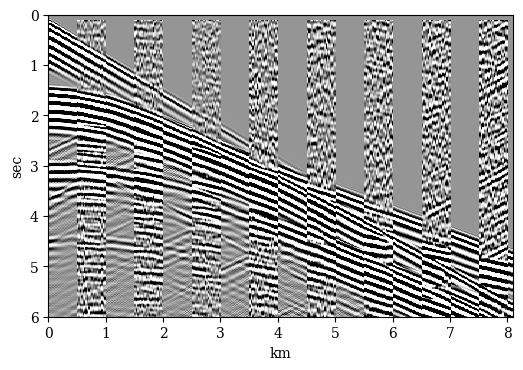

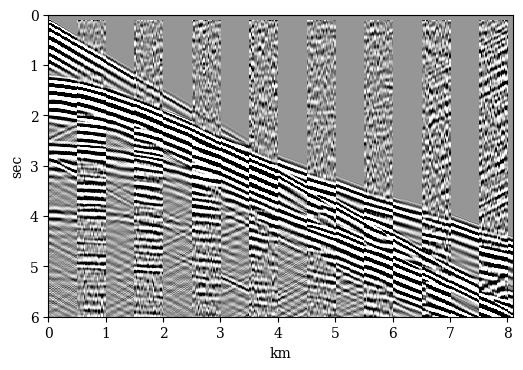

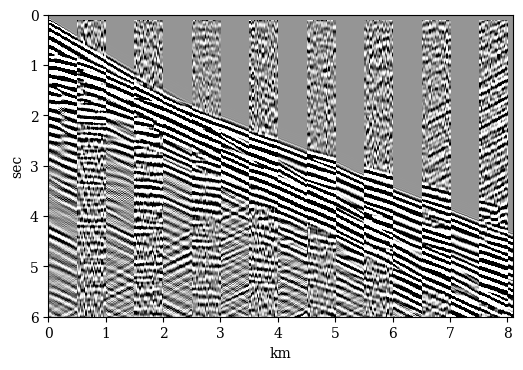

In [31]:
d.verbose = 0    # don't show redundant print outs
# importlib.reload(vis)
if d.DT is None:
    d.DT = 0.002

shots = d.get_shots(keys=['_p.'])
# shots = [ld.bandpass(s, fs=1./(d.DT * d.NDT), **par_bp) for s in d.get_shots(keys=['_p'])]

par_shot = {'vmin': -0.05, 'vmax': 0.05}
if shots:
    print(f'Read {len(shots)} shots {shots[0].shape} into list')
    for i in [int(np.floor(x)) for x in np.linspace(0, len(shots)-1, 3)]:
        try:
#             shot_s = divmax(shots[i])
#             shot_f = divmax(data_p[i, :, ::d.NDT])
            shot_s = shots[i]
            shot_f = data_p[i, :, ::d.NDT]
#             vis.plot_compare_stripes(shot_s, shot_f, title=f'{i+1}/{len(shots)}', **par_shot)
            vis.plot_compare_stripes(shot_s, shot_f, pclip=0.0125, colorbar=False, dt=d.DT, dx=dx)
        except:
            print(f'Failed to fetch data for i={i}')

3975.0 8025.0


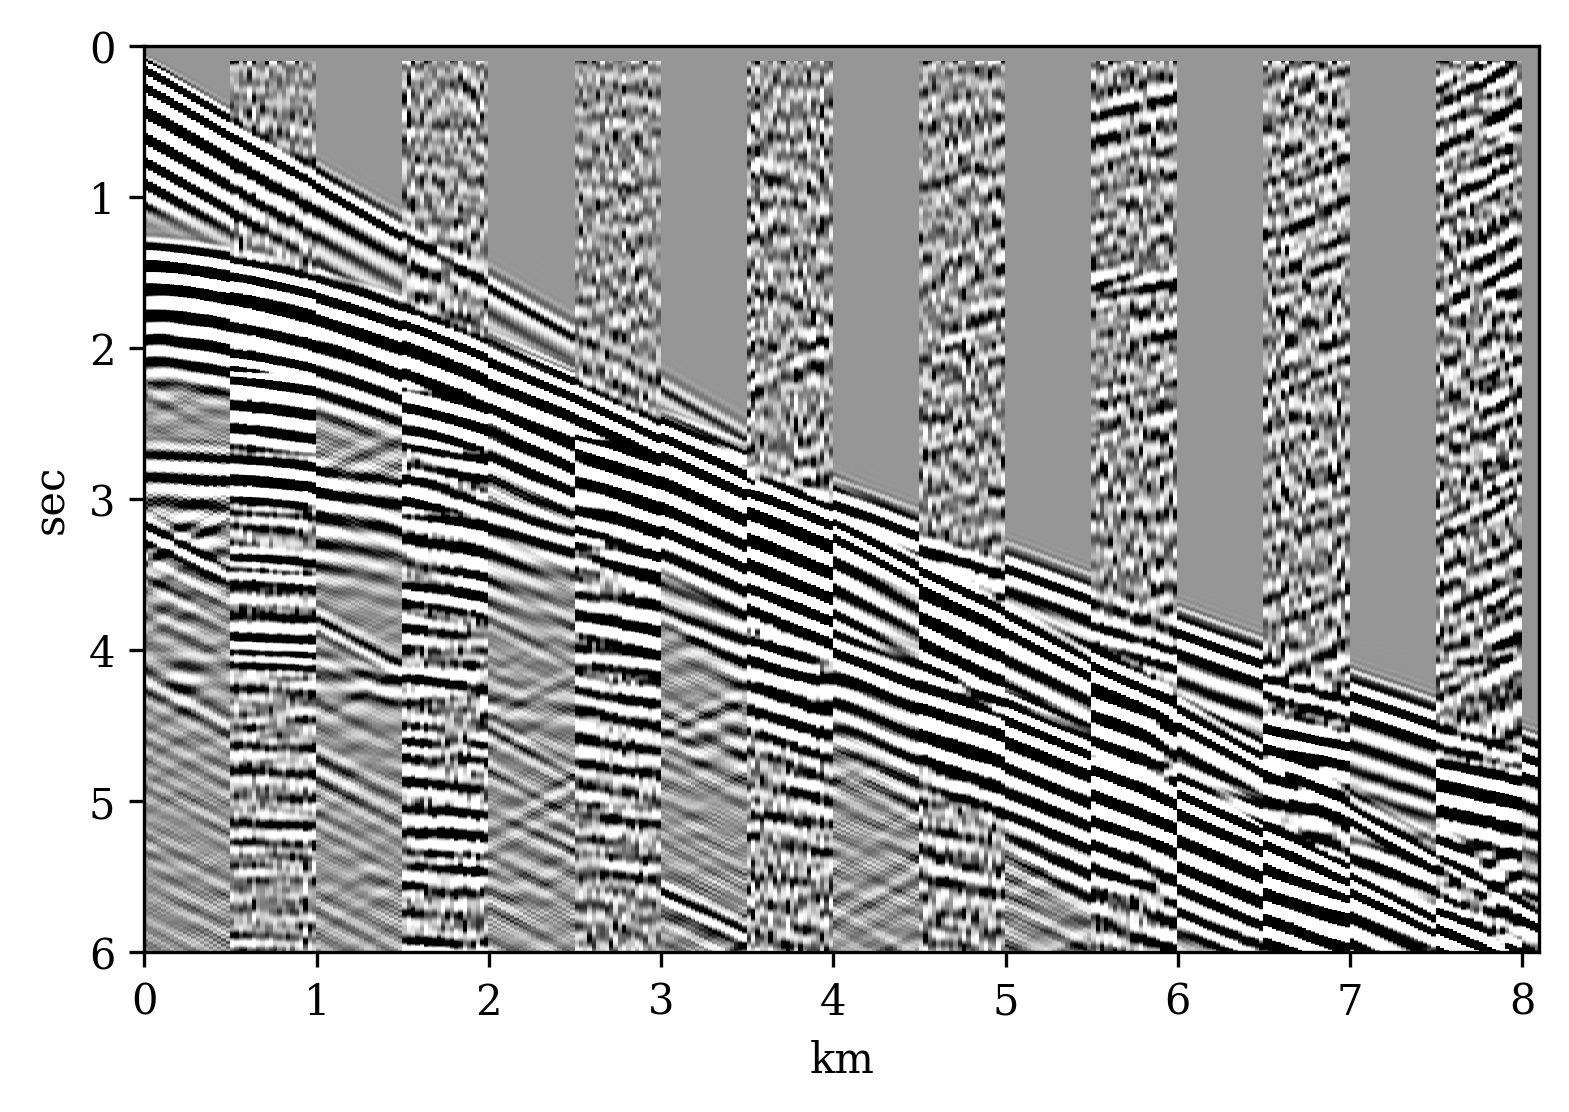

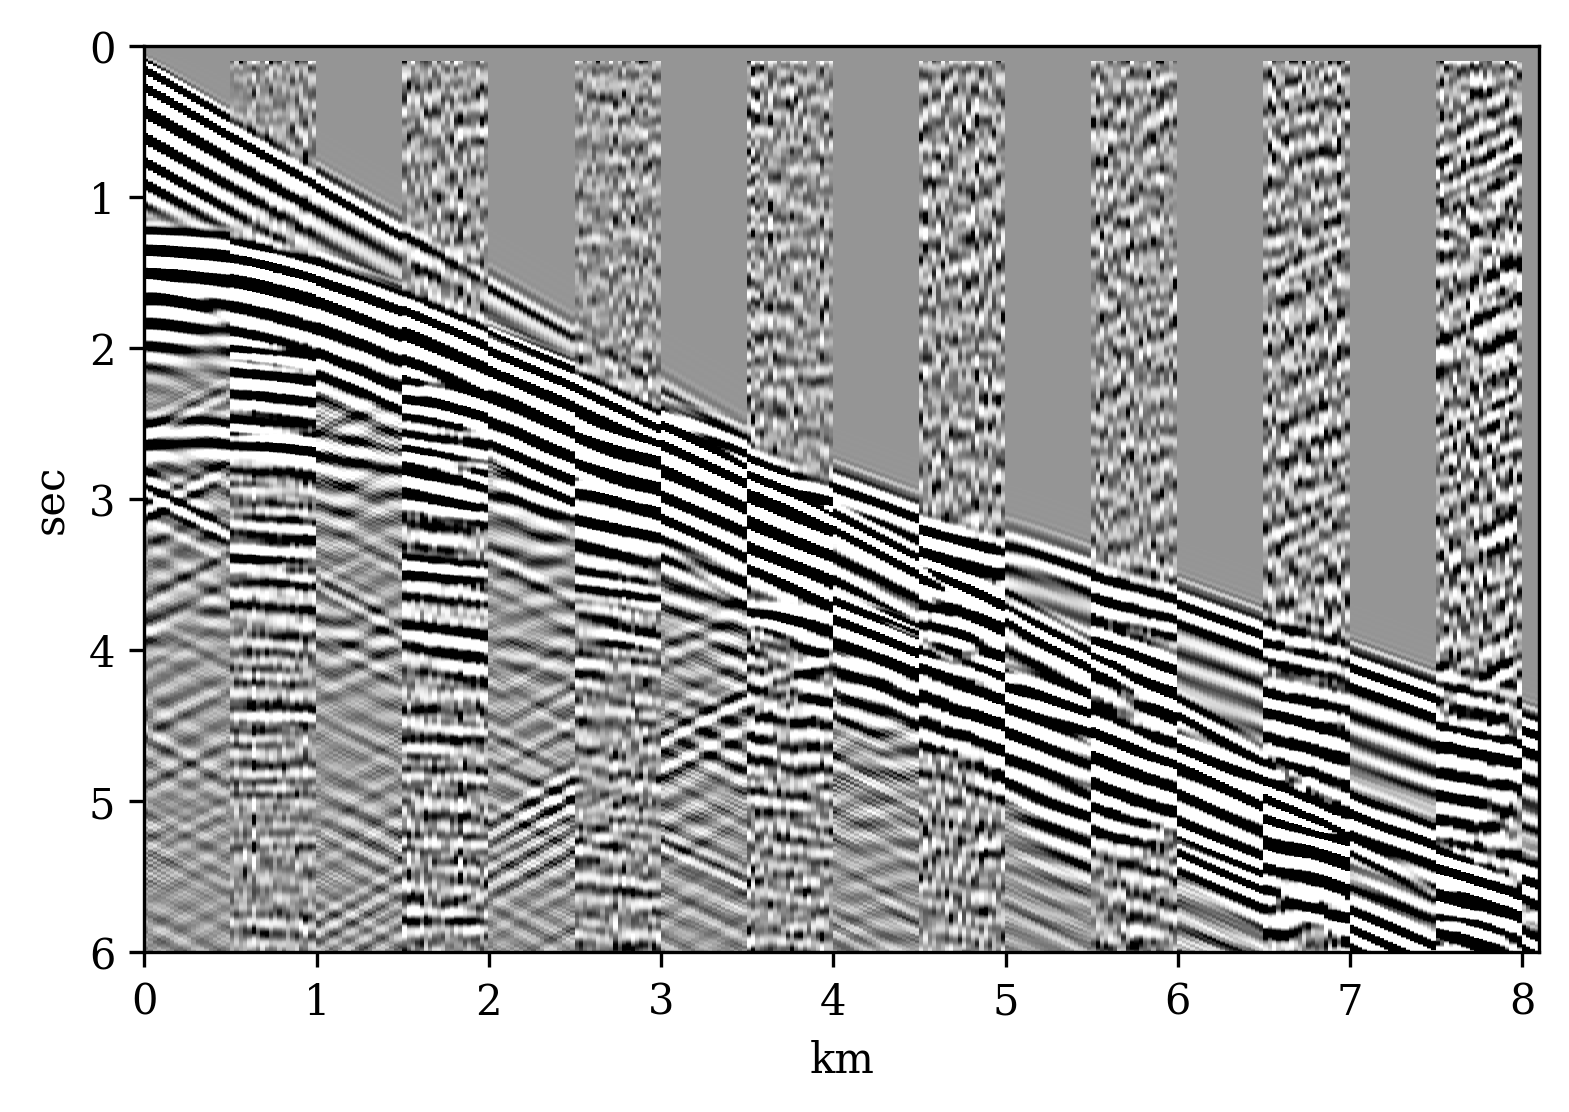

In [32]:
# Selected shots for comparison
print(src.x[24], src.x[51])
selected_shot_ids = [24, 51]

for i in selected_shot_ids:
    shot_s = shots[i]
    shot_f = data_p[i, :, ::d.NDT]
    vis.plot_compare_stripes(shot_s, shot_f, pclip=0.0125, colorbar=False, dt=d.DT, dx=dx, dpi=300)

In [33]:
# wavefield_amp_ratio
print(np.max(np.abs(shot_f)) / np.max(np.abs(shot_s)) )

1.3713859048452077


In [34]:
# Images for FWI workflow picture
# for i in range(6):
#     vis.plot_shot(shots[i], pclip=0.25, axis='off', figsize=(5, 6))

In [35]:
print(src.x[48])

7575.0


# Compare syn and field

Total sources: 85
Syn wavelets:	(85, 500)	-19284.29	26554.27
Field wavelets:	(85, 500)	-16728.73	24865.97
[0, 9, 18, 28, 37, 46, 56, 65, 74, 84]


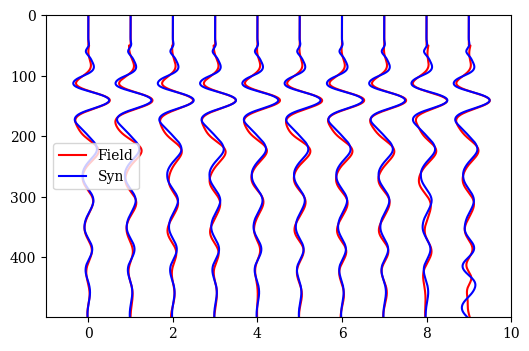

In [36]:
wavelets_s = []
wavelets_f = []
for i, shot in enumerate(shots):
    no, nt = 1, 500
    wavelets_s.append(shot[:no, :nt].copy())
    wavelets_f.append(data_p[i, :no, :nt:d.NDT].copy())
print(f'Total sources: {len(wavelets_f)}')
wavelets_s = np.concatenate(wavelets_s, 0)
wavelets_f = np.concatenate(wavelets_f, 0)

# !!! DO THIS IN FIELD DATA APPLICATION !!!
# THIS MAKES SYNTHETIC AND FIELD COMPARABLE
# OTHERWISE THERE IS INSANE AMPLITUDE MISMATCH
# wavelets_f /= np.max(wavelets_f)
# wavelets_f *= wavelets_s.max()

print('Syn wavelets:\t{}\t{:.2f}\t{:.2f}'.format(wavelets_s.shape, wavelets_s.min(), wavelets_s.max()))
print('Field wavelets:\t{}\t{:.2f}\t{:.2f}'.format(wavelets_f.shape, wavelets_f.min(), wavelets_f.max()))

vis.plot_wiggles([wavelets_f, wavelets_s], n=10, colors=['r', 'b'], legend=['Field', 'Syn'])

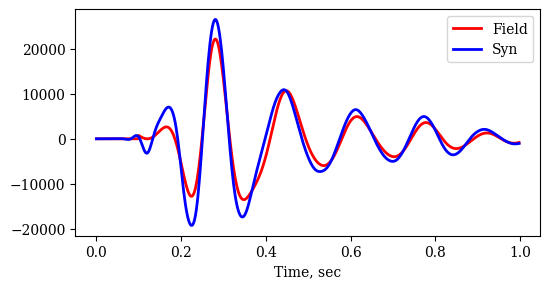

In [37]:
if shots:
    tvec = np.arange(nt) * d.DT
    plt.figure(figsize=(6,3)); 
    trace_idx = 0
    plt.plot(tvec, wavelets_f[trace_idx,:], 'r', lw=2, label='Field')
    plt.plot(tvec, wavelets_s[trace_idx,:], 'b', lw=2, label='Syn')
    # plt.plot(tvec, _dplotted[0][0], 'r', lw=2, label='Field')
    # plt.plot(tvec, _dplotted[1][0], 'b', lw=2, label='Syn')
    plt.legend()
    plt.xlabel('Time, sec')
#     vis.savefig('wavelet_syn_field.png')

# REPLACE FIELD DATA BY MARM DATA

In [38]:
# data_p = np.concatenate([np.expand_dims(s, 0) for s in shots], 0)
# print(data_p.shape)

In [39]:
data_p_backup = data_p.copy()
print(data_p_backup.shape, d.DT)

(85, 324, 3000) 0.002


In [40]:
geom = np.repeat(np.repeat(np.arange(1, data_p.shape[-1]+1)[np.newaxis, ...] * d.DT, data_p.shape[1], 0)[np.newaxis, ...], data_p.shape[0], 0) ** 0.75
geom = np.ones_like(geom)
data_p = data_p_backup * geom
# data_p = data_p_backup

(85, 324, 3000) -36872.38619092324 29173.327396346955


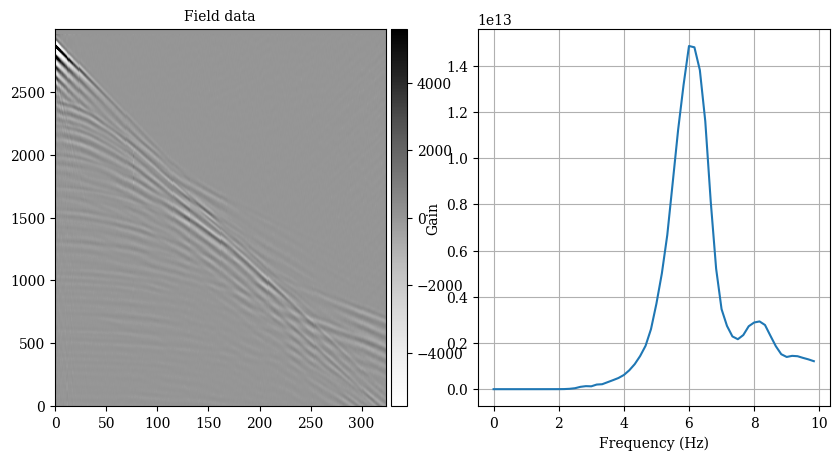

In [41]:
# data_p = np.concatenate([np.expand_dims(s, 0) for s in shots], 0)
print(data_p.shape, data_p.min(), data_p.max())
dref = np.mean(data_p, 0)
fig, ax = plt.subplots(1, 2, figsize=(10, 5))
vis.plot_shot(dref, title='Field data', pclip=0.25, colorbar=True, ax=ax[0])
vis.plot_spectrum(dref, dt=0.002, fmax=10, title='Spectrum', ax=ax[1])

## Extract amplitude of the low-frequency band
Take the range of overlap area of low and ulow bands

(324, 3000) -2133.4930213888415 2117.997796092733


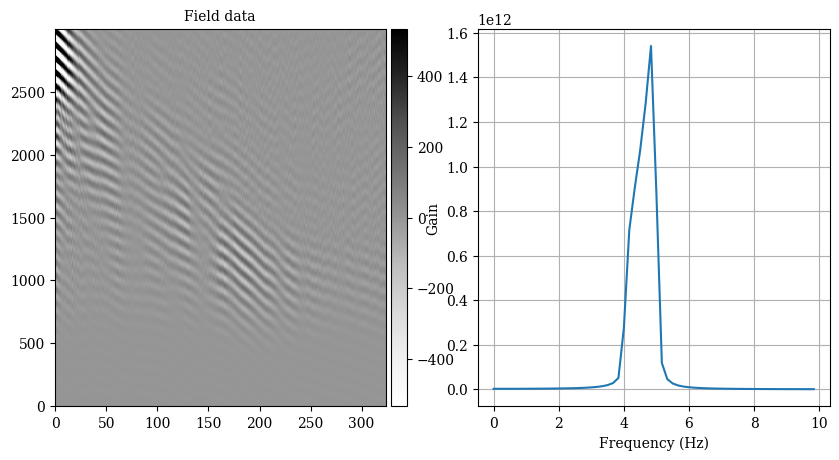

In [42]:
par_ref = {'fs': 1/0.002, 'flo': 4, 'fhi': 5, 'order': 8, 'btype': 'band'}
dref_low = ld.bandpass(dref, **par_ref)
dref_min = dref_low.min()
dref_max = dref_low.max()
print(dref_low.shape, dref_min, dref_max)
fig, ax = plt.subplots(1, 2, figsize=(10, 5))
vis.plot_shot(dref_low, title='Field data', pclip=0.25, colorbar=True, ax=ax[0])
vis.plot_spectrum(dref_low, dt=0.002, fmax=10, title='Spectrum', ax=ax[1])

## Save field data to a new folder in /su/

In [43]:
def copy_su_from_to(path_from, path_to):
    """ Copy files matching *.su.* from one folder to another folder"""
    os.makedirs(path_to, exist_ok=True)
    su_files = glob.glob(path_from + '/*.su.*')
    su_files = [f for f in su_files if '.it' not in f]
    print(f'Found {len(su_files)} *.su.* files in {path_from}')

    commands = []
    print(f'Copy files from {path_from} to {path_to}')
    for f in su_files:
        commands.append(f'cp {f} {path_to}')
    with multiprocessing.Pool() as pool:
        pool.map(os.system, commands)

In [44]:
root_su_field = os.path.join(d._root_su, 'field/')
copy_su_from_to(d._root_su, root_su_field)

Found 85 *.su.* files in ./out_cgg_hard_log6_lpm_extended5/su
Copy files from ./out_cgg_hard_log6_lpm_extended5/su to ./out_cgg_hard_log6_lpm_extended5/su/field/


In [45]:
def get_fnames_pattern(pattern):    
    fnames = natsorted(glob.glob(pattern))
    fnames = [f for f in fnames if '.it' not in f]
    print(f'{len(fnames)} files found in {pattern}')
    return fnames

fnames = get_fnames_pattern(root_su_field + '*.su.*')

85 files found in ./out_cgg_hard_log6_lpm_extended5/su/field/*.su.*


# Write field data into created .su files

In [46]:
print(data_p.shape, geom.shape)
geom_slice = geom[0, ...]

(85, 324, 3000) (85, 324, 3000)


In [47]:
for i, f in enumerate(fnames):
    with segyio.su.open(f, "r+", endian='little', ignore_geometry=True) as dst:
        tmp = data_p[i, :, ::d.NDT] / geom_slice[..., ::d.NDT]
        dst.trace = tmp
        print(f, dst.tracecount, tmp.shape, end='\r')

/home/ovcharoo/work/env_torch/lib/python3.8/site-packages/segyio/utils.py:23: RuntimeWarning: Implicit conversion from float64 to float32 (narrowing)
  warnings.warn(msg.format(x.dtype, dtype), RuntimeWarning)


# Predict by trained DNN

Create subfolder for **predicted low frequencies** (< 5 Hz)

In [48]:
root_pred = os.path.join('/'.join(root_su_field.split('/')[:-2]), 'pred/')
copy_su_from_to(path_from=root_su_field, path_to=root_pred)

Found 85 *.su.* files in ./out_cgg_hard_log6_lpm_extended5/su/field/
Copy files from ./out_cgg_hard_log6_lpm_extended5/su/field/ to ./out_cgg_hard_log6_lpm_extended5/su/pred/


Create subfolder for **predicted ultra-low frequencies** (< 2.5 Hz)

In [49]:
# root_pred_ulow = os.path.join('/'.join(root_su_field.split('/')[:-2]), 'pred_ulow/')
# copy_su_from_to(path_from=root_su_field, path_to=root_pred_ulow)

Create dataloader and cube of field data

In [50]:
fnames_low = get_fnames_pattern(f'{root_pred}*.shot*')
# fnames_ulow = get_fnames_pattern(f'{root_pred_ulow}*.shot*')

85 files found in ./out_cgg_hard_log6_lpm_extended5/su/pred/*.shot*


In [51]:
def make_cube_and_loader(fnames):
    cube_cgg = []
    for i, f in enumerate(fnames):
        clear_output()
        print(f'{i+1}/{len(fnames)}\n{f}')
        with segyio.su.open(f, "r+", endian='little', ignore_geometry=True) as dst:
            raw = dst.trace.raw[:] * geom_slice
            print(raw.shape)
            cube_cgg.append(np.expand_dims(raw, 0))

    cube_cgg = np.concatenate(cube_cgg, 0)
    (cube_cgg_h, cube_cgg_l, cube_cgg_m, cube_cgg_u), _, scalers =  sd.split_hlm(cube_cgg, sd.par_default)
    loader_cgg = sd.TriLoader(cube_cgg_h, cube_cgg_l, cube_cgg_m, cube_cgg_u, np.zeros_like(cube_cgg_u), sd.par_default)
    return loader_cgg, cube_cgg, scalers

loader_cgg, cube_cgg, scalers = make_cube_and_loader(fnames)

path_noise = os.path.join('/data/oleg/data/', 'test_cgg_data5')
cube_hf = ld.make_noise_cube(os.path.join(path_noise, 'cube_dst_te_h.npy'))
cube_mf = ld.make_noise_cube(os.path.join(path_noise, 'cube_dst_te_m.npy'))

# loader_cgg = ld.NoiseAdder(ld.JointLoader(loader_cgg, loader_cgg), cube_hf, cube_mf)
# for i in range(cube_cgg_h.shape[0]):
#     cube_cgg[i, ...] = loader_cgg.__getitem__(i)[0]

85/85
./out_cgg_hard_log6_lpm_extended5/su/field/seis_p.su.shot85
(324, 3000)
Start split for (85, 324, 3000)
Start making cubes from lists for list 85, where each sublist 8
(85, 324, 376)
(85, 324, 376)
(85, 324, 376)
(85, 324, 376)
(85, 324, 376)
(85, 324, 376)
(85, 324, 376)
(85, 324, 376)
(85, 324, 376) (85, 324, 376) (85, 324, 376) (85, 324, 376) (85, 324, 376)
Load /data/oleg/data/test_cgg_data5/cube_dst_te_h.npy
(80, 324, 376)
(80, 324, 446)
Load /data/oleg/data/test_cgg_data5/cube_dst_te_m.npy
(80, 324, 376)
(80, 324, 446)


In [52]:
# for i in range(0, 100, 10):
#     vis.plot_shot(loader_cgg.__getitem__(i)[0][0,...], pclip=0.1)

Load pre-trained network. Due to silly implementation of inference I load the same network 3 times to get 3 different outputs :)

In [53]:
root_dump = '/data/oleg/dump/'
net = Ensemble(Encoder(1), 
                     Head(layers=[(96, 32), (32, 16)], layers_out=(16, 1), kernel_sizes=[4, 4], strides=[2, 2], pads=[1, 1]), 
                     HeadOld(layers=[(96, 32), (32, 1)], kernel_sizes=[3, 3], strides=[1, 1]),
                     path_to_model1, 10)

# net1 = Ensemble(Encoder(1), 
#          Head(layers=[(96, 32), (32, 16)], layers_out=(16, 2), kernel_sizes=[4, 4], strides=[2, 2], pads=[1, 1]), 
#          HeadOld(layers=[(96, 32), (32, 1)], kernel_sizes=[3, 3], strides=[1, 1]), path_to_model1, 5)
                
# net2 = Ensemble(Encoder(1), 
#          Head(layers=[(96, 32), (32, 16)], layers_out=(16, 2), kernel_sizes=[4, 4], strides=[2, 2], pads=[1, 1]), 
#          HeadOld(layers=[(96, 32), (32, 1)], kernel_sizes=[3, 3], strides=[1, 1]),
#          path_to_model2, 5)

# net = Blend([net1, net2])

Load weights for _encoder
Loading model from /data/oleg/dump/paper_pear_lpm_0/0_net_encoder.pth
Load weights for _data
Loading model from /data/oleg/dump/paper_pear_lpm_0/0_net_data.pth
Load weights for _model
Loading model from /data/oleg/dump/paper_pear_lpm_0/0_net_model.pth
Loading history from /data/oleg/dump/paper_pear_lpm_0/history_encoder.pkl...
Loading history from /data/oleg/dump/paper_pear_lpm_0/history_data.pkl...
Loading history from /data/oleg/dump/paper_pear_lpm_0/history_model.pkl...
Failed to load history form /data/oleg/dump/paper_pear_lpm_0/history_model.pkl, [Errno 2] No such file or directory: '/data/oleg/dump/paper_pear_lpm_0/history_model.pkl'
Loading history from /data/oleg/dump/paper_pear_lpm_0/history_lr.pkl...
Load sigmas from /data/oleg/dump/paper_pear_lpm_0
Load weights for _encoder
Loading model from /data/oleg/dump/paper_pear_lpm_1/0_net_encoder.pth
Load weights for _data
Loading model from /data/oleg/dump/paper_pear_lpm_1/0_net_data.pth
Load weights for _

In [54]:
def match_amp(have, want):
    max_have = np.max(have[20:50,:-50])
    max_want = np.max(want[20:50,:-50])
    return have / max_have * max_want

# def match_amp(df, ds):
#     rmsf = vis.rms(df)
#     rmss = vis.rms(ds)
#     return ds / rmss * rmsf

## Predict low frequencies

In [55]:
def hard_blend(dat_lo, dat_hi, dt, fedge):
    assert dat_lo.shape == dat_hi.shape
    h, w = dat_lo.shape[-2:]
    dat_lo_fx = np.fft.rfft(dat_lo, w)
    dat_hi_fx = np.fft.rfft(dat_hi, w)
    ff = np.fft.rfftfreq(dat_hi.shape[-1], d=dt)

    where_left = np.where(ff < fedge)[0]
    where_right = np.where(ff >= fedge)[0]
    print(where_right.shape)
    
#     should_be_this = dat_hi_fx[..., where_right[0]]
#     got_this = dat_lo_fx[..., where_right[-1]]
#     ratio = should_be_this / got_this
    
#     dat_lo_fx[..., where_left] = dat_lo_fx[..., where_left] * np.expand_dims(ratio, -1)
#     print(should_be_this.shape, got_this.shape, ratio.shape)
        
    dat_lo_fx[..., where_right] = dat_hi_fx[..., where_right]
    out = np.fft.irfft(dat_lo_fx, w)
    return out

In [56]:
dt = 0.002

# Bandpass filters for Low
# par_blend_low_low ={'fs': 1/dt, 'upscale': 8, 'pad': (0, 8),'fhi': 5, 'btype': 'low'}
par_blend_low_high ={'fs': 1/dt, 'upscale': 8, 'pad': (0, 8), 'flo': 4, 'btype': 'high'}
# par_ref_low = {'fs': 1/dt, 'flo': 4, 'fhi': 5, 'order': 8, 'btype': 'band'}

data_l = np.zeros_like(data_p)

for i,f in enumerate(fnames_low):
    clear_output()
    print(f'{i+1}/{len(fnames)}\n{f}')
    with segyio.su.open(f, "r+", endian='little', ignore_geometry=True) as dst:
        dh_cgg = loader_cgg.__getitem__(i)[0]
        
        # Predict low-frequencies and upscale it to 2 ms sampling
        lfp = signal.resample(net.predict(dh_cgg, pred_idx=0, pred_chan=1), 3000, axis=-1)
        
        # Take input data (strict zero < 4 Hz) and upsample it to 2 ms sampling
        hf = signal.resample(dh_cgg[0,...], 3000, axis=-1)
        # And match it with respective range of field data
        hf = match_amp(hf, ld.bandpass(data_p[i, ...], **par_blend_low_high))
        
        # Now extract range [4, 5] Hz and normalize low-freq prediction on it
        should_be_this = np.abs(ld.bandpass(hf, **par_ref)).max()
        got_this = np.abs(ld.bandpass(lfp, **par_ref)).max()  
        ratio = should_be_this / got_this
        lf = lfp * ratio
        print(should_be_this, got_this, ratio)
        
        hft = data_p[i, :, :]
        blend = hard_blend(lf, hft, dt, 4)
        
        data_l[i, ...] = blend / geom_slice
        
        dst.trace = blend / geom_slice
        
        
#         # Blend high-freq and low-freq data
#         blend = lf + hf
        
#         dst.trace = match_amp(blend, hf)

85/85
./out_cgg_hard_log6_lpm_extended5/su/pred/seis_p.su.shot85
1615.2870832866347 0.5340851641523734 3024.3998367754634
(1477,)


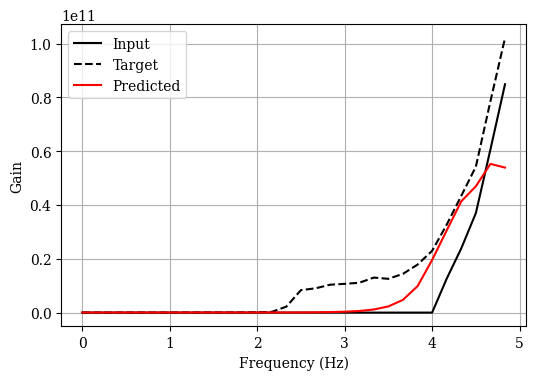

In [57]:
dictlist = [
           {'data': hf, 'line': 'k', 'label': 'Input'},
           {'data': hft, 'line': 'k--', 'label': 'Target'},
           {'data': lf, 'line': 'r', 'label': 'Predicted'},
           ]

vis.plot_spectra_dictlist(dictlist, dt=dt, fmax=5)

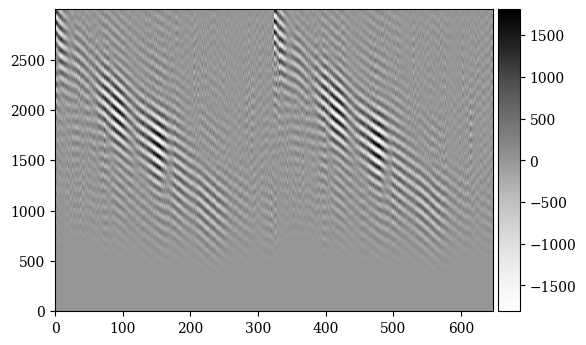

In [58]:
# Compare shared range from 4 to 5 Hz in time-offset domain
want_this = ld.bandpass(hft, **par_ref)
have_this = ld.bandpass(blend, **par_ref)
vis.plot_shot([want_this, have_this], pclip=0.9)

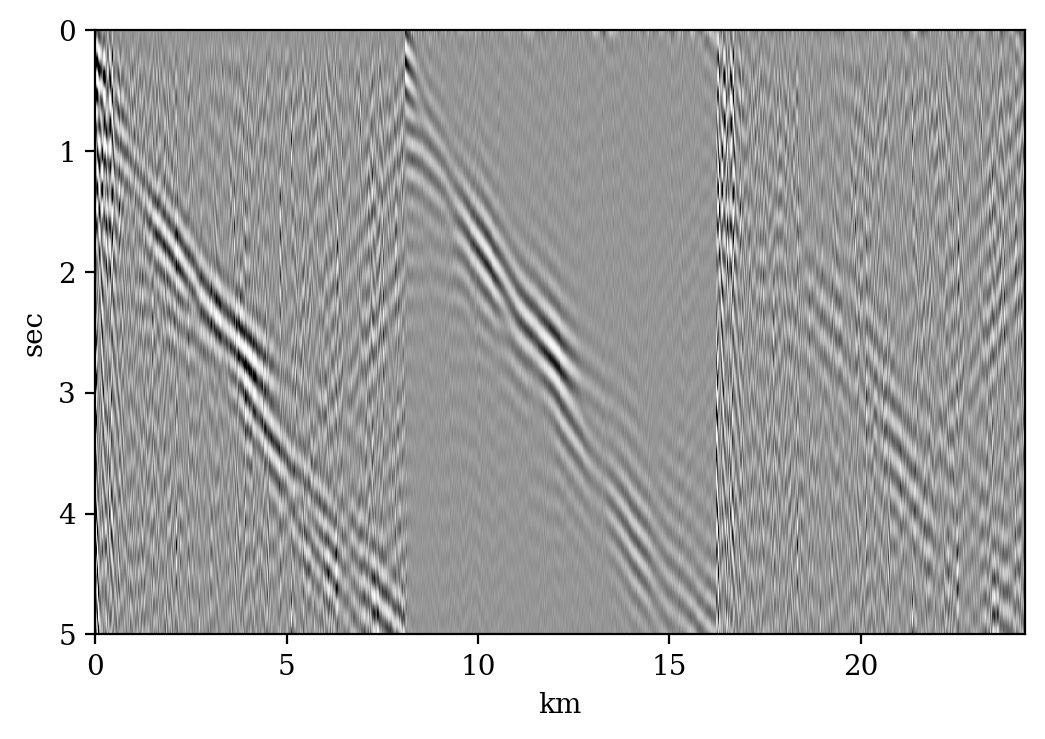

In [59]:
importlib.reload(vis)
# Compare shared range from 4 to 5 Hz in time-offset domain
par_known = par_ref.copy()
# par_known['flo'] = 2.5
# par_known['fhi'] = 4
# par_known['btype'] = 'band'

par_known['fhi'] = 4
par_known['btype'] = 'low'

want_this = ld.bandpass(hft, **par_known)[..., :-500]
have_this = ld.bandpass(blend, **par_known)[..., :-500]

vis.plot_shot([want_this, have_this, want_this - have_this], pclip=0.5, dt=dt, dx=dx, colorbar=False, dpi=200)

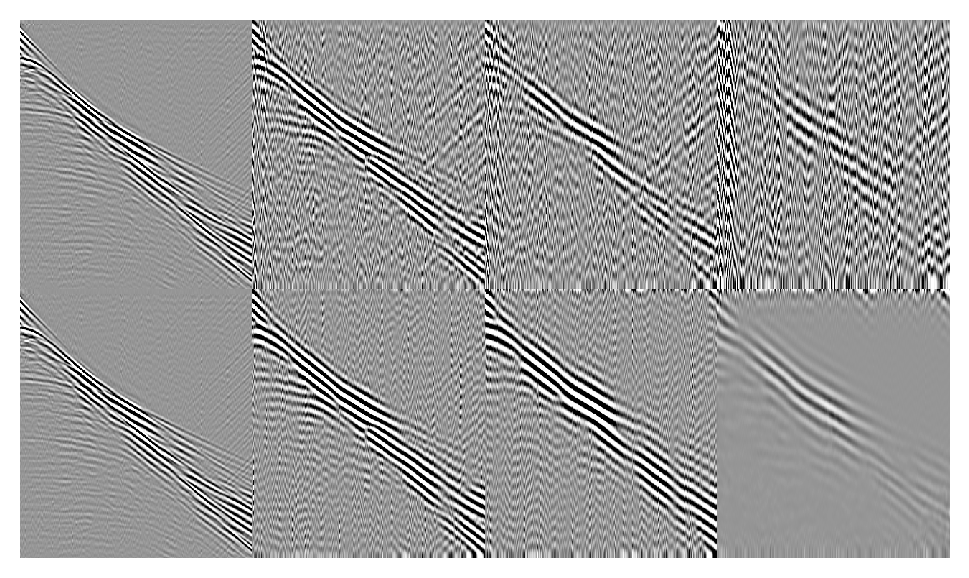

In [60]:
par_bp_input = par_ref.copy(); par_bp_input['flo'] = 4; par_bp_input['btype'] = 'high';
par_bp_low = par_ref.copy(); par_bp_low['fhi'] = 5; par_bp_low['btype'] = 'low';
par_bp_mid = par_ref.copy(); par_bp_mid['fhi'] = 4; par_bp_mid['btype'] = 'low';
par_bp_ulow = par_ref.copy(); par_bp_ulow['fhi'] = 3; par_bp_ulow['btype'] = 'low';
# par_bp_uulow = par_ref.copy(); par_bp_uulow['fhi'] = 2; par_bp_uulow['btype'] = 'low';

d_input = ld.bandpass(hft, **par_bp_input)[..., ::8]
d_low = ld.bandpass(hft, **par_bp_low)[..., ::8]
d_mid = ld.bandpass(hft, **par_bp_mid)[..., ::8]
d_ulow = ld.bandpass(hft, **par_bp_ulow)[..., ::8]
# d_uulow = ld.bandpass(hft, **par_bp_uulow)[..., ::8]


dp_input = ld.bandpass(blend, **par_bp_input)[..., ::8]
dp_low = ld.bandpass(blend, **par_bp_low)[..., ::8]
dp_mid = ld.bandpass(blend, **par_bp_mid)[..., ::8]
dp_ulow = ld.bandpass(blend, **par_bp_ulow)[..., ::8]
# dp_uulow = ld.bandpass(blend, **par_bp_uulow)[..., ::8]

# vis.plot_nxm([[d_input, d_low, d_mid, d_ulow], 
#               [dp_input, dp_low, dp_mid, dp_ulow]], 
#              pclip=0.0015, colorbar=True)
amp_ref = d_input
vis.plot_nxm([[match_amp(d_input, amp_ref), 
               match_amp(d_low, amp_ref), 
               match_amp(d_mid, amp_ref), 
               match_amp(d_ulow, amp_ref)], 
             [match_amp(dp_input, amp_ref), 
               match_amp(dp_low, amp_ref), 
               match_amp(dp_mid, amp_ref), 
               match_amp(dp_ulow, amp_ref)], ], 
             pclip=0.125, colorbar=False, dpi=200)

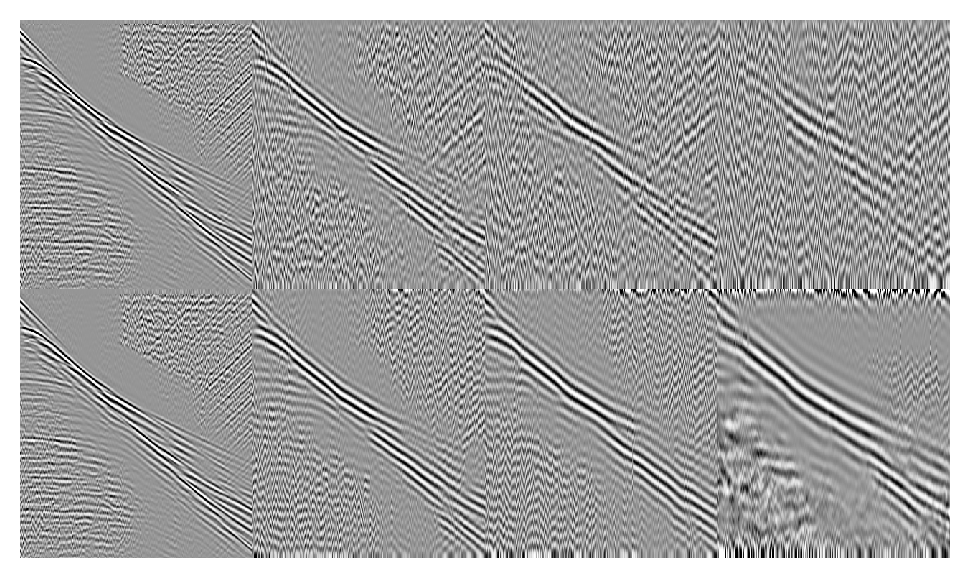

In [61]:
par_agc = {'win': 150, 'amp': 1, 'eps': 1e-6}
vis.plot_nxm([[vis.agc(d_input, **par_agc)[0], 
               vis.agc(d_low, **par_agc)[0], 
               vis.agc(d_mid, **par_agc)[0], 
               vis.agc(d_ulow, **par_agc)[0]], 
             [vis.agc(dp_input, **par_agc)[0], 
              vis.agc(dp_low, **par_agc)[0], 
              vis.agc(dp_mid, **par_agc)[0], 
              vis.agc(dp_ulow, **par_agc)[0]]], 
             pclip=0.25, colorbar=False, dpi=200)

In [62]:
print(dt)

0.002


(85, 324, 3000)


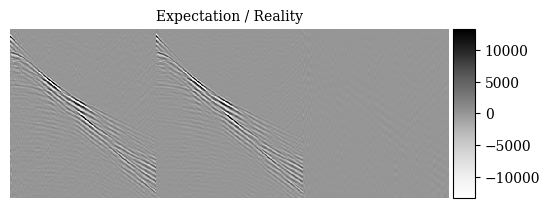

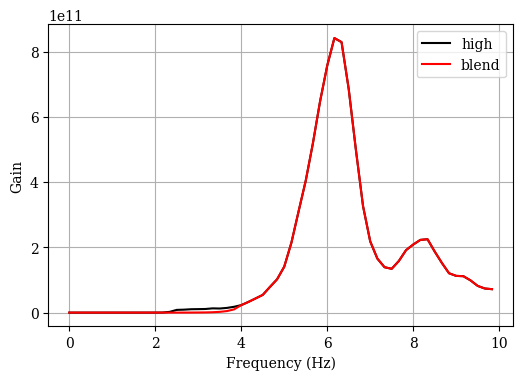

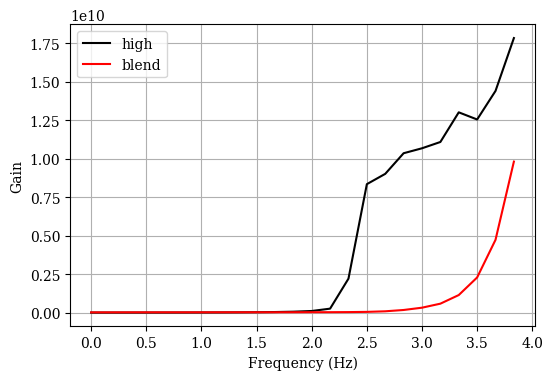

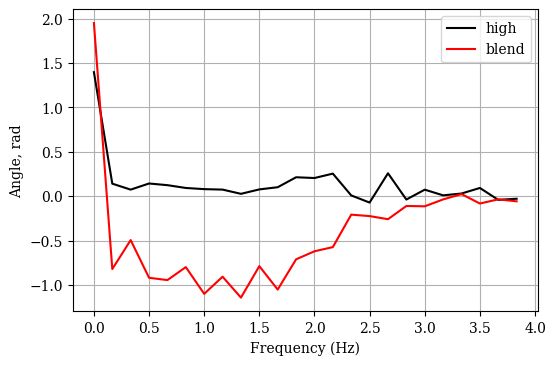

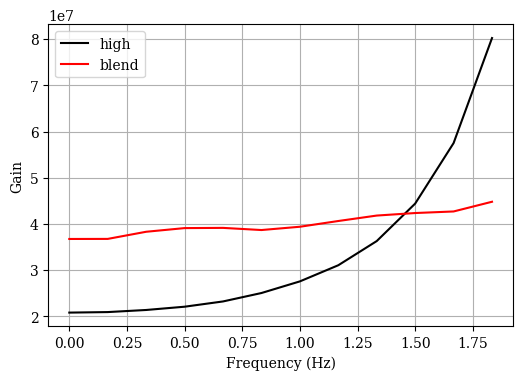

In [63]:
# Expected ideal low frequencies
print(data_p.shape)

# hft = data_p[i, :, :]
# blend = hard_blend(lf, hft, dt, 4)

# print('Low true {}\n\tmin:\t{:e}\tmax:\t{:e}'.format(lft.shape, lft.min(), lft.max()))
# print('Low predicted {}\n\tmin:\t{:e}\tmax:\t{:e}'.format(lf.shape, lf.min(), lf.max()))

hfts = hft[:, ::8]
lfs = blend[:, ::8]
vis.plot_shot([hfts, lfs, hfts - lfs], axis=False, pclip=0.5, title='Expectation / Reality')

# Plot data and spectra
dictlist = [
           {'data': hft, 'line': 'k', 'label': 'high'},
           {'data': blend, 'line': 'r', 'label': 'blend'},
           ]

vis.plot_spectra_dictlist(dictlist, dt=dt, fmax=10)
vis.plot_spectra_dictlist(dictlist, dt=dt, fmax=4)
vis.plot_spectra_dictlist(dictlist, dt=dt, fmax=4, phase=True)
vis.plot_spectra_dictlist(dictlist, dt=dt, fmax=2)

(85, 324, 3000)
Low true (324, 3000)
	min:	-2.898688e+03	max:	3.081649e+03
Low predicted (324, 3000)
	min:	-2.851943e+03	max:	2.921592e+03


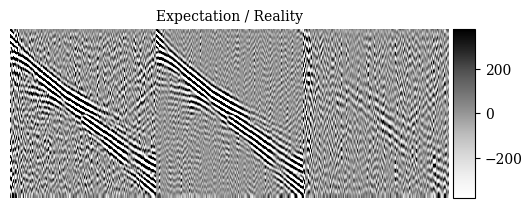

In [64]:
# Expected ideal low frequencies
print(data_p.shape)
lft = ld.bandpass(data_p[i, :, :], fs=1/dt, fhi=5, btype='low', order=8)
lfs = ld.bandpass(blend, fs=1/dt, fhi=5, btype='low', order=8)

print('Low true {}\n\tmin:\t{:e}\tmax:\t{:e}'.format(lft.shape, lft.min(), lft.max()))
print('Low predicted {}\n\tmin:\t{:e}\tmax:\t{:e}'.format(lfs.shape, lfs.min(), lfs.max()))

lfts = lft[..., ::8]
lfss = lfs[..., ::8]
# lfs_match = match_amp(lfts, lfs)
vis.plot_shot([lfts, lfss, lfts - lfss], axis=False, pclip=0.125, title='Expectation / Reality')

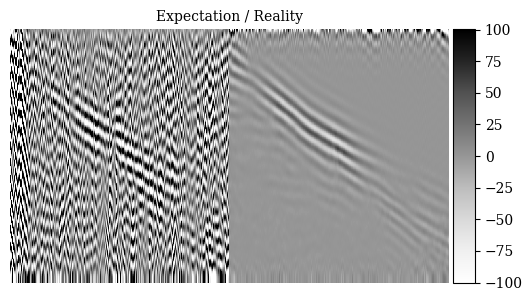

In [65]:
vis.plot_shot([ld.bandpass(lft, fs=1/dt, fhi=3, btype='low', order=8)[..., ::8], 
               ld.bandpass(lfs, fs=1/dt, fhi=3, btype='low', order=8)[..., ::8]], 
              axis=False, pclip=0.125, title='Expectation / Reality')

## Predict ultra-low frequencies

In [66]:
# Bandpass filters for Ultra low
par_blend_ulow_low ={'fs': 1/dt, 'upscale': 8, 'pad': (0, 8), 'fhi': 2.5, 'btype': 'low', 'order': 8}


# for i,f in enumerate(fnames_ulow):
#     clear_output()
#     print(f'{i+1}/{len(fnames)}\n{f}')
#     with segyio.su.open(f, "r+", endian='little', ignore_geometry=True) as dst:
#         dh_cgg = loader_cgg.__getitem__(i)[0]
#         ufp = signal.resample(net.predict(dh_cgg, pred_idx=0, pred_chan=0), 3000, axis=-1)
        
#         # Now extract range [0, 2.5] Hz from low-freq data predicted earlier
#         should_be_this = np.abs(ld.bandpass(data_l[i, ...], **par_blend_ulow_low)).max()
#         got_this = np.abs(ld.bandpass(ufp, **par_blend_ulow_low)).max()  
#         ratio = should_be_this / got_this
#         uf = ufp * ratio / 10
#         print(should_be_this, got_this, ratio)
        
#         blend_u = hard_blend(lf, data_l[i, ...], dt, 2.5)
        
#         dst.trace = blend_u / geom_slice

In [67]:
# mpl.rcParams['figure.dpi']= 100

# uf = ld.bandpass(blend_u, **par_blend_ulow_low)
# uft = ld.bandpass(data_p[i, :, :], **par_blend_ulow_low)

# print('Expectation {}\n\tmin:\t{:e}\tmax:\t{:e}'.format(uft.shape, uft.min(), uft.max()))
# print('Reality {}\n\tmin:\t{:e}\tmax:\t{:e}'.format(uf.shape, uf.min(), uf.max()))

# vis.plot_shot([uft[:, ::8], uf[:,::8]], axis=None, pclip=0.1)

In [68]:
# vis.plot_shot(uf[:, ::8], axis=None, pclip=0.25, colorbar=True)

# Compare data from true folder and low folder
Maybe writing is broken?

In [69]:
# fnames_true = glob.glob(f'{root_fwi}su/field/seis*')
# print(len(fnames_true))

# fnames_ulow = glob.glob(f'{root_fwi}su/pred_ulow/seis*')
# fnames_ulow = glob.glob(f'{root_fwi}su/pred/seis*')
# print(len(fnames_ulow))

# tops, bottoms = [], []
# for ftrue, fulow in zip(fnames_true[::10], fnames_ulow[::10]):
#     with segyio.su.open(ftrue, "r+", endian='little', ignore_geometry=True) as dst:
#         dtrue = dst.trace.raw[:uf.shape[0]]
#     with segyio.su.open(fulow, "r+", endian='little', ignore_geometry=True) as dst:
#         dulow = dst.trace.raw[:uf.shape[0]]
# #     print(dtrue.shape, dulow.shape)
#     tops.append(ld.bandpass(dtrue, **par_blend_ulow_low)[..., ::8])
# #     tops.append(ld.bandpass(dtrue, **par_blend_low_high)[..., ::8])
# #     bottoms.append(dulow[..., ::8])
#     bottoms.append(ld.bandpass(dulow, **par_blend_ulow_low)[..., ::8])
    
# print(tops[0].shape, bottoms[0].shape)

# vis.plot_nxm([tops, bottoms] ,figsize = (5* len(tops), 5), colorbar=False, pclip=0.01)
# #     vis.plot_shot([ld.bandpass(dtrue, **par_blend_ulow_low), ld.bandpass(dulow, **par_blend_ulow_low)], pclip=0.1)

## Predict initial model

In [70]:
# These are box conditions used for generation of training data
box_max = 4000.
box_min = 1490.

In [71]:
from skimage.transform import resize
pred = np.zeros((len(fnames), *dh_cgg.shape[-2:]))
for i, f in enumerate(fnames):
    clear_output()
    print(f'{i+1}/{len(fnames)}\n{f}')
    with segyio.su.open(f, "r+", endian='little', ignore_geometry=True) as dst:
        dh_cgg = loader_cgg.__getitem__(i)[0]
        p = resize(net.predict(dh_cgg, pred_idx=1, pred_chan=0), dh_cgg.shape[-2:])
        p += 1
        p /= 2
        # The scalar is a "tunable" parameter to match the trend
        p *= 0.5 * box_max
        p += box_min
        pred[i, ...] = p

85/85
./out_cgg_hard_log6_lpm_extended5/su/field/seis_p.su.shot85


In [72]:
print(pred.shape)
ndsrc = int(dsrc // dx)
print(ndsrc, dh_cgg.shape)
shp = dh_cgg.shape[-2:]

(85, 324, 376)
6 (1, 324, 376)


In [73]:
box_min

1490.0

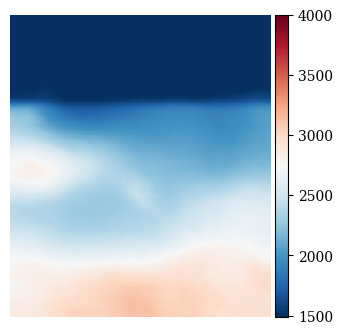

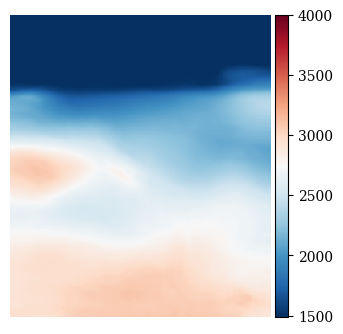

In [74]:
mpl.rcParams['figure.dpi']= 100
for i in range(0, pred.shape[0], 50):
     vis.plot_shot(pred[i, ...], cmap='RdBu_r', vmin=box_min, vmax=box_max, axis=False)

(828, 376)
(828, 376)


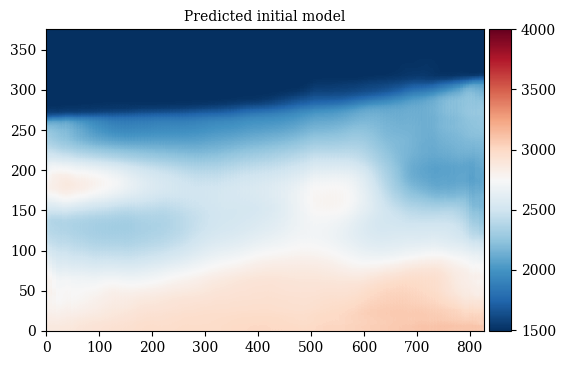

In [75]:
pred_model = np.zeros((shp[0] + (len(fnames)-1)*ndsrc, shp[-1]))
print(pred_model.shape)
overlaps = np.zeros_like(pred_model)
print(overlaps.shape)
for i in range(len(fnames)):
    pred_model[ndsrc*i:ndsrc*i+dh_cgg.shape[-2], :] += pred[i,...]
    overlaps[ndsrc*i:ndsrc*i+dh_cgg.shape[-2], :] += 1
pred_model = pred_model / overlaps
vis.plot_shot(pred_model, cmap='RdBu_r', vmin=box_min, vmax=box_max, title='Predicted initial model')

In [76]:
print(vp.max(), vp.min())
print(pred_model.shape, model.vp.shape)

3054.1727632409516 1490.0
(828, 376) (152, 944)


In [77]:
from scipy import signal, ndimage

# Rotate to be aligned with modeling domain
vp_net = np.flipud(pred_model.T)
print(vp_net.shape)

# Want this sizes
want_nz = model.vp.shape[0] # stretch to become like what used for forward modeling
want_nx = vp_net.shape[-1]  # keep same dim along offset axis

# Actual resize
vp_net = resize(vp_net.astype(np.float32), (want_nz, want_nx))
print(vp_net.shape)

(376, 828)
(152, 828)


First source at 15
(152, 944) 828
Mirror data till xid = 225
Mirror data till xid = 344


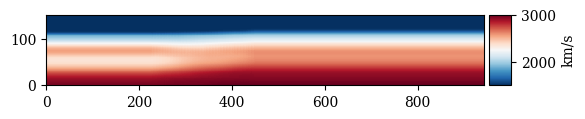

In [78]:
# vp_net[vp_net > 0.85 * np.max(vp_net)] = 0.85 * np.max(vp_net)

idx_src_0 = int(src.x[0] // dx)
print(f'First source at {idx_src_0}')

# Embed prediction into placeholder
vp_p = np.zeros_like(model.vp)
print(vp_p.shape, vp_net.shape[-1])
idx_end = min(vp_net.shape[-1], vp_p.shape[-1])
vp_p[:, idx_src_0:idx_src_0+idx_end] = vp_net[:, :idx_end]

# Fill left padding
left_pad = idx_src_0 + int(14* idx_src_0)
print(f'Mirror data till xid = {left_pad}')
# vp_p[:, :left_pad] = np.flip(vp_p[:, left_pad:2*left_pad], -1)
vp_p[:, :left_pad] = np.repeat(vp_p[:, left_pad:left_pad+1], left_pad, -1)


# Fill right padding
# right_pad = int(0.2 * vp_p.shape[-1])
right_pad = vp_p.shape[-1] - vp_baseline.shape[-1]
print(f'Mirror data till xid = {right_pad}')
# vp_p[:, -right_pad:] = np.flip(vp_p[:, -2*right_pad:-right_pad], -1)
vp_p[:, 450:] = np.repeat(vp_p[:, 450:451], vp_p.shape[-1] - 450, -1)

vis.plot_model(vp_p)

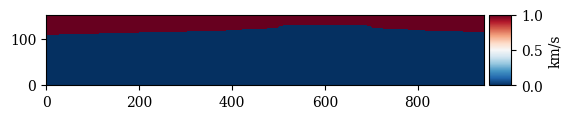

In [79]:
wb_taper = np.where(model.vp < 1.01 * model.vp.min(), 1, 0)
vis.plot_model(wb_taper)

In [80]:
vp_p[wb_taper.astype(bool)] = model.vp[wb_taper.astype(bool)]
# vp_p = gaussian_filter(vp_p.copy(), **sigma_truncate)

# ---------------------------
# ASSUME KNOWN EARLY PART
# ---------------------------
# mask = vp_p < vp
# mask[:100, :] = False
# vp_p = np.where(mask, vp, vp_p)

vs_p = vp_p.copy() / (3 ** 0.5)
vs_p = np.where(vp_p < 1.01 * np.min(vp_p), 0, vs_p)

# density, [kg/m3] 
rho_p = 1e3*0.3 * vp_p.copy()**0.25
rho_p = np.where(vp_p < 1.01 * np.min(vp_p), 1000, rho_p)

# shift = -8
# taper_model = np.roll(wb_taper.copy(), shift, 0)
# taper_model[shift:, :] = 1.
# vis.plot_model(taper_model)
# vp_p[taper_model.astype(bool)] = vp[taper_model.astype(bool)]
# vs_p[taper_model.astype(bool)] = vs[taper_model.astype(bool)]
# rho_p[taper_model.astype(bool)] = rho[taper_model.astype(bool)]

# vp_p = gaussian_filter(vp_p.copy(), **sigma_truncate)
# vs_p = gaussian_filter(vs_p.copy(), **sigma_truncate)
# rho_p = gaussian_filter(rho_p.copy(), **sigma_truncate)

(152, 944) 1490.0 3004.79443359375
(152, 944) 0.0 1734.8188750948407
(152, 944) 1000.0 2221.1349518124675


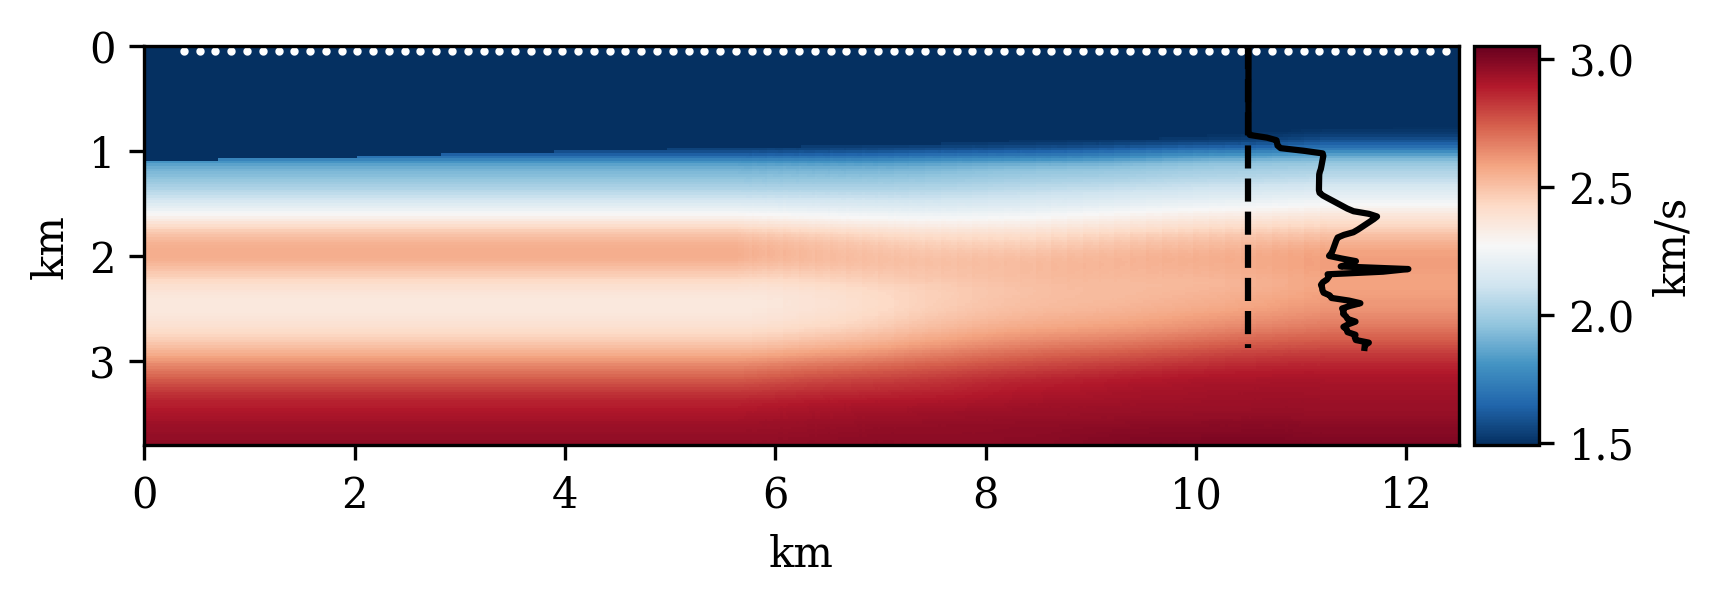

In [81]:
nx0 = 500
limits_vp = {'vmin': model.vp.min() / 1000, 'vmax': model.vp.max() / 1000}
# importlib.reload(vis)
vis.plot_log_model(vp_p, dx, nx0, nz0, src, dpi=300, log=wlog, log_location=log_location, **limits_vp)

print(vp_p.shape, vp_p.min(), vp_p.max())
print(vs_p.shape, vs_p.min(), vs_p.max())
print(rho_p.shape, rho_p.min(), rho_p.max())

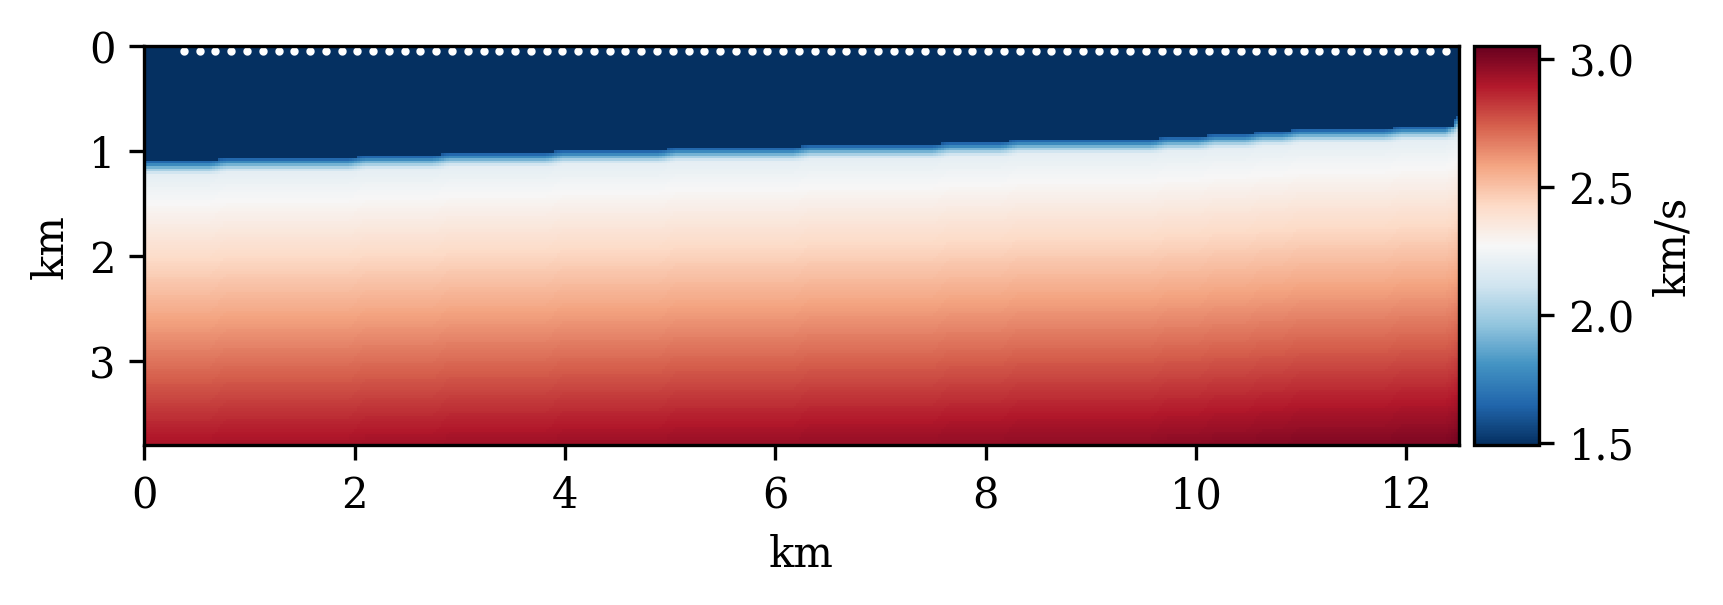

In [116]:
vis.plot_log_model(model.vp, dx, nx0, nz0, src, dpi=300, **limits_vp)

In [117]:
# num_pix = 10
# vps = []
# for i, wb in enumerate(wb_args):
#     the_log = vp_p[:, i:i+1].copy()
#     waterdepth=33
    
#     the_log[-wb:] = box_min
#     the_log[-wb-num_pix:-wb] = wlog[-waterdepth-num_pix:-waterdepth]
    
#     vps.append(the_log)
# vp_p = np.concatenate(vps, -1)
# print(vp_p.shape)

# vis.plot_acquisition(vp_p[:, :500], dx, src, rec, log=log_dict)

In [118]:
# importlib.reload(vis)
# vis.plot_log_model(vp_p, dx, nx0, nz0, axis=False, **limits_vp)

## Crop predicted model
Large part of the model (beyond last source) was only to get full-offset seismic data. When running inversion it is not needed so we cut it down

In [85]:
# 672 / 8
xcut = 672

wb_taper = wb_taper[:, :xcut]

model_init = api.Model(vp_p[:, :xcut], vs_p[:, :xcut], rho_p[:, :xcut], dx)


# model_init = model
print(model_init)

vp:	(152, 672), 1490.0000, 3004.7944 m/s

vs:	(152, 672), 0.0000, 1734.8189 m/s

rho:	(152, 672), 1000.0000, 2221.1350 m/s

dx:	25.0000
Size:
	OX:	min 0.0000	max 16775.0000 m
Size:
	OZ:	min 0.0000	max 3775.0000 m


(116, 1) (152, 944)


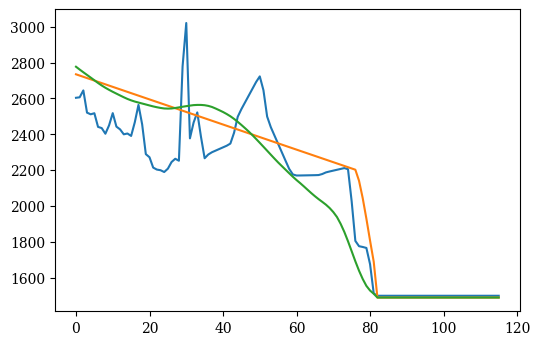

In [86]:
print(wlog.shape, vp.shape)

fig, ax = plt.subplots(1,1)
ax.plot(wlog)
ax.plot(vp[-len(wlog):, log_idx])
ax.plot(vp_p[-len(wlog):, log_idx])

# Full-waveform inversion
Invert for elastic properties `vp`, `vs` and `rho`, given `x` and `y` velocity components of wavefield 

## Initial velocity model
Smooth background model with true water bottom and shallow sediments

116 (152, 672) 116


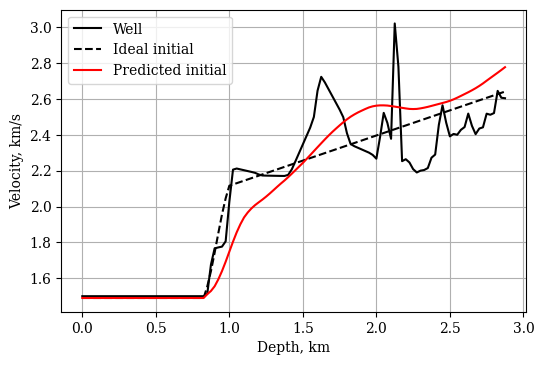

In [87]:
# ax = plot_model(np.concatenate((model_init.vp, model_init.vs, model_init.rho), 1))
# plot_logs(model_log, model_init, log_idx)

fig, ax = plt.subplots(1,1); 
ax_depth = np.arange(len(wlog)) * dx / 1000
# ax_depth = np.arange(len(log_linear)) * dx / 1000
ax.plot(ax_depth, wlog[::-1] / 1000, 'k', label='Well')
ax.plot(ax_depth, log[::-1] / 1000, 'k--', label='Ideal initial')

# log_pred = model_init.vp[-len(wlog):, log_idx]

log_pred = model_init.vp[-len(log):, log_idx]
ax.plot(ax_depth, log_pred[::-1] / 1000, 'r', label='Predicted initial')

nwater = 33#33
dummy = np.zeros_like(model.vp)
dummy[-nwater:, :] = 1.
log_taper = np.min(log_pred) + dummy[:, log_idx] * (np.max(log_pred) - np.min(log_pred))
log_taper = np.min(log_pred) + wb_taper[-len(wlog):, log_idx] * (np.max(log_pred) - np.min(log_pred))
# ax.plot(ax_depth, log_taper[::-1]  / 1000, 'b', label='Taper')
# 
# ax.plot(ax_depth, log_linear[::-1] / 1000, 'k--', label='Linear')
ax.set_ylabel('Velocity, km/s')
ax.set_xlabel('Depth, km')
ax.grid(True)
ax.legend()

print(len(wlog), model_init.vp.shape, len(model_init.vp[:len(wlog)]))

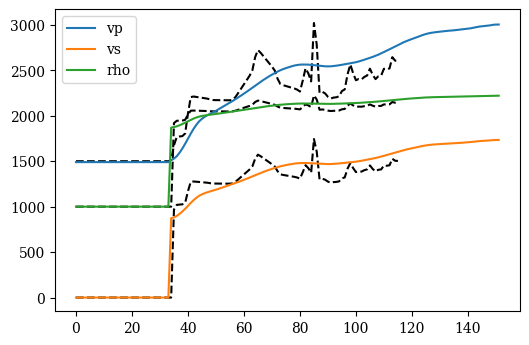

In [88]:
plot_logs(model_log, model_init, log_idx)

## Stages of inversion
Use default parameters, except high- and low-pass corner frequencies of Butterworth filter

### Ultra-low frequencies

In [89]:
# par_stages_fwi = {'inv_vs_iter': 2,
#                  'inv_rho_iter': 2,
#                  'normalize': 1,
#                  'spatfilter': 4,
#                  'order': 6,
# #                  'wd_damp': 0.5,
# #                   'wd_damp1': 0.5, 
#                  }

# d.fwi_stages = []
# freqs_high = [2.5]
# grad_smoothing = [2]
# for i, freq in enumerate(freqs_high):
#     d.add_fwi_stage(fc_high=freq, 
#                     wd_damp=grad_smoothing[i],
#                     wd_damp1=grad_smoothing[i],
#                     **par_stages_fwi)
#     print(f'Stage {i+1}:\n\t{d.fwi_stages[i]}\n')

In [90]:
d.SWS_TAPER_GRAD_HOR = 1
d.GRADT1, d.GRADT2 = 25, 30

In [91]:
# # Turn off if it breaks something
# d.SCALEFAC = 1.5     # reduce step by this
# d.EPS_SCALE = 0.01   # eps_scale * dgrad/dm

(152, 672) (152, 672)
Save (672, 152) as binary to ./out_cgg_hard_log6_lpm_extended5/taper/taper.bin
Save (672, 152) as binary to ./out_cgg_hard_log6_lpm_extended5/taper/taper_u.bin
Save (672, 152) as binary to ./out_cgg_hard_log6_lpm_extended5/taper/taper_rho.bin


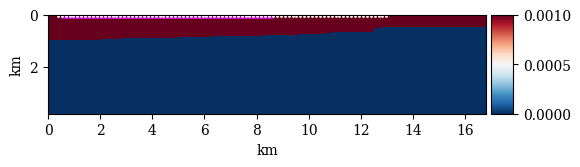

In [92]:
# import loaders as ld
# # Gradient tapering
# d.SWS_TAPER_GRAD_VERT = 0
# d.SWS_TAPER_CIRCULAR_PER_SHOT = 0   # enable grad tapering around sources

d.VPUPPERLIM = 3000.
d.VPLOWERLIM = 1490.
d.VSUPPERLIM = 2500.
d.VSLOWERLIM = 0.
d.RHOUPPERLIM = 2500.
d.RHOLOWERLIM = 1000.

d.SWS_TAPER_FILE = 1

taper = np.zeros_like(model_init.vp)
print(taper.shape,wb_taper.shape)
shift = 4
# shift = 8
taper[shift:, :] = wb_taper[:-shift,:] # water mask
# taper[-nwater:, :] = 1.
# taper[-28:, :] = 1.
# taper[:, 650:] = 1.
# taper[:,-10:] = 1. # right
# taper[:,:10] = 1. # left
# taper[:5,:] = 1. # bottom
# nwater= 30 - shift
# taper[-nwater:, :] = 1.

# plt.imshow(taper)
if d.SWS_TAPER_FILE:
    os.makedirs(d._root_tapers, exist_ok=True)
    ld.write_bin(np.fliplr((1 - taper.astype(np.float32).T)), os.path.join(d._root_tapers, 'taper.bin'))
    ld.write_bin(np.fliplr((1 - taper.astype(np.float32).T)), os.path.join(d._root_tapers, 'taper_u.bin'))
    ld.write_bin(np.fliplr((1 - taper.astype(np.float32).T)), os.path.join(d._root_tapers, 'taper_rho.bin'))
    vis.plot_acquisition(taper, dx, src, rec)

## Run inversion

In [93]:
# d.DATA_DIR = f'{root_fwi}su/pred_ulow/seis'
# # d.DATA_DIR = f'{root_fwi}su/field/seis'

# # d.DATA_DIR = f'{root_fwi}su/pred/seis'
# print(f'Target data: {d.DATA_DIR}')

In [94]:
d.WRITE_STF = 0
d.NPROCX = 8
d.NPROCY = 2
d.verbose = 1
par_fwi_runtime = {'run_command': 'mpirun -np 32', 'disable': True}

In [95]:
# d.fwi(model_init, src, rec, **par_fwi_runtime)

### Visualize FWI outputs
It will not hurt to make sure that paths and model dims are up to date. This is necessary when you only want to plot pictures, without running modeling or FWI

In [96]:
d.set_model(model_init)
# root_fwi_u = root_fwi[:-1] + '_u/'
# d.save_folder = root_fwi
# d.set_paths()
print(d.save_folder)


Init model:
	152 x 672, dx = 25.0 m
./out_cgg_hard_log6_lpm_extended5/


### Inverted model
The code ouputs inverted models for every elastic property at every FWI stage. Change `vp` to `vs` or `rho` to explore respective outputs

In [97]:
# mpl.rcParams['figure.dpi']= 300
# d.verbose = 2

# models, fnames = d.get_fwi_models(['vp', 'stage'], return_filenames=True)
# for m, f in zip(models, fnames):
#     vis.plot_log_model(m, dx, nx0, nz0, src, log=wlog, log_location=log_location, **limits_vp)
# mpl.rcParams['figure.dpi']= 100

### Well-logs
Plot logs in true model (dashed) and inverted models (solid) for every inversion stage

In [98]:
# # Load inverted models from all stages
# vvr = {'vp': None, 'vs': None, 'rho': None}
# for k in vvr.keys():
#     vvr[k], fnames = d.get_fwi_models([k + '_stage'], return_filenames=True)

# for i in range(len(vvr['vp'])):
#     plot_logs(model_log, api.Model(vvr['vp'][i], vvr['vs'][i], vvr['rho'][i], dx), log_idx)

### Gradients

In [99]:
# d.verbose = 0
# grads, fnames = d.get_fwi_gradients(return_filenames=True)
# for g, f in zip(grads, fnames):
#     plot_model(g, f)

In [100]:
# d.help()

## Low-frequencies

In [101]:
par_stages_fwi = {'inv_vs_iter': 3,
                 'inv_rho_iter': 5,
                 'normalize': 2,
                 'order': 6,
                 }

d.fwi_stages = []
freqs_high = [3, 4, 5, 6, 7]
grad_smoothing = [2, 1.5, 0.5, 0.25, 0.125]
lnorms = [2, 2, 2, 2, 2, 2]
spatfilters = [4, 4, 0, 0, 0, 0]
for i, freq in enumerate(freqs_high):
    d.add_fwi_stage(fc_high=freq, 
                    wd_damp=grad_smoothing[i],
                    wd_damp1=grad_smoothing[i],
                    lnorm=lnorms[i],
                    spatfilter=spatfilters[i],
                    **par_stages_fwi)
    print(f'Stage {i+1}:\n\t{d.fwi_stages[i]}\n')

Stage 1:
	{'PRO': 0.01, 'TIME_FILT': 1, 'FC_LOW': 0.0, 'FC_HIGH': 3, 'ORDER': 6, 'TIME_WIN': 0, 'GAMMA': 20, 'TWIN-': 0.0, 'TWIN+': 0.0, 'INV_VP_ITER': 0, 'INV_VS_ITER': 3, 'INV_RHO_ITER': 5, 'INV_QS_ITER': 0, 'SPATFILTER': 4, 'WD_DAMP': 2, 'WD_DAMP1': 2, 'EPRECOND': 3, 'LNORM': 2, 'ROWI': 0, 'STF_INV': 0, 'OFFSETC_STF': -4.0, 'EPS_STF': 0.1, 'NORMALIZE': 2, 'OFFSET_MUTE': 0, 'OFFSETC': 10, 'SCALERHO': 0.5, 'SCALEQS': 1.0, 'ENV': 1, 'N_ORDER': 0}

Stage 2:
	{'PRO': 0.01, 'TIME_FILT': 1, 'FC_LOW': 0.0, 'FC_HIGH': 4, 'ORDER': 6, 'TIME_WIN': 0, 'GAMMA': 20, 'TWIN-': 0.0, 'TWIN+': 0.0, 'INV_VP_ITER': 0, 'INV_VS_ITER': 3, 'INV_RHO_ITER': 5, 'INV_QS_ITER': 0, 'SPATFILTER': 4, 'WD_DAMP': 1.5, 'WD_DAMP1': 1.5, 'EPRECOND': 3, 'LNORM': 2, 'ROWI': 0, 'STF_INV': 0, 'OFFSETC_STF': -4.0, 'EPS_STF': 0.1, 'NORMALIZE': 2, 'OFFSET_MUTE': 0, 'OFFSETC': 10, 'SCALERHO': 0.5, 'SCALEQS': 1.0, 'ENV': 1, 'N_ORDER': 0}

Stage 3:
	{'PRO': 0.01, 'TIME_FILT': 1, 'FC_LOW': 0.0, 'FC_HIGH': 5, 'ORDER': 6, 'TIME_WIN':

In [102]:
def get_model_last():
    all_fnames = []
    vps, fnames = d.get_fwi_models(['vp', 'stage'], return_filenames=True)
    all_fnames += fnames
    vss, fnames = d.get_fwi_models(['vs', 'stage'], return_filenames=True)
    all_fnames += fnames
    rhos, fnames = d.get_fwi_models(['rho', 'stage'], return_filenames=True)
    all_fnames += fnames

    if all_fnames:
        for f in all_fnames:
            if not f.split('/')[-1] in os.listdir(f'{root_fwi}start/'):
                command = f'cp {f} {root_fwi}start/'
                print(command)
                os.system(command)

    if vps:
        print(f'Init new starting model from {fnames[-1]}')
        model_last = api.Model(vps[-1], vss[-1], rhos[-1], dx)
    return model_last

# model_last = get_model_last()
model_last = model_init

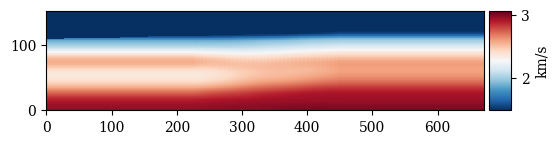

In [103]:
vis.plot_model(model_last.vp / 1000, **limits_vp)

In [104]:
# d.DATA_DIR = f'{root_fwi}su/field/seis'

d.DATA_DIR = f'{root_fwi}su/pred/seis'
print(f'Target data: {d.DATA_DIR}')

Target data: ./out_cgg_hard_log6_lpm_extended5/su/pred/seis


In [105]:
d.verbose = 1
d.fwi(model_last, src, rec, **par_fwi_runtime)
# d.fwi(model_init, src, rec, **par_fwi_runtime)

Target data: ./out_cgg_hard_log6_lpm_extended5/su/pred/seis
Create FWI workflow file in ./out_cgg_hard_log6_lpm_extended5/seis_fwi.inp
Init model:
	152 x 672, dx = 25.0 m
Check max source frequency:
	min Vs: 868.8753659652847 m/s
	min Vp: 1490.0 m/s
	Number of gridpoints per minimum wavelength = 3.69
	Maximum source wavelet frequency = 9.418703154095226 Hz
Check domain decomposition for parallelization:
	in X-direction, NX % NPROCX, 672 % 8 = 0
	in Y-direction, NY % NPROCY, 152 % 2 = 0
Write ./out_cgg_hard_log6_lpm_extended5/start/model.vp
Write ./out_cgg_hard_log6_lpm_extended5/start/model.vs
Write ./out_cgg_hard_log6_lpm_extended5/start/model.rho
Custom taper from taper.bin (vp), taper_u.bin (vs) and taper_rho.bin (rho)
Enable streamer mode!
	source 1: ./out_cgg_hard_log6_lpm_extended5/receiver/receivers_shot_1
	source 2: ./out_cgg_hard_log6_lpm_extended5/receiver/receivers_shot_2
	source 3: ./out_cgg_hard_log6_lpm_extended5/receiver/receivers_shot_3
	source 4: ./out_cgg_hard_log6_lp

	wavelet 31: ./out_cgg_hard_log6_lpm_extended5/wavelet/wavelet_shot_31.dat
	wavelet 32: ./out_cgg_hard_log6_lpm_extended5/wavelet/wavelet_shot_32.dat
	wavelet 33: ./out_cgg_hard_log6_lpm_extended5/wavelet/wavelet_shot_33.dat
	wavelet 34: ./out_cgg_hard_log6_lpm_extended5/wavelet/wavelet_shot_34.dat
	wavelet 35: ./out_cgg_hard_log6_lpm_extended5/wavelet/wavelet_shot_35.dat
	wavelet 36: ./out_cgg_hard_log6_lpm_extended5/wavelet/wavelet_shot_36.dat
	wavelet 37: ./out_cgg_hard_log6_lpm_extended5/wavelet/wavelet_shot_37.dat
	wavelet 38: ./out_cgg_hard_log6_lpm_extended5/wavelet/wavelet_shot_38.dat
	wavelet 39: ./out_cgg_hard_log6_lpm_extended5/wavelet/wavelet_shot_39.dat
	wavelet 40: ./out_cgg_hard_log6_lpm_extended5/wavelet/wavelet_shot_40.dat
	wavelet 41: ./out_cgg_hard_log6_lpm_extended5/wavelet/wavelet_shot_41.dat
	wavelet 42: ./out_cgg_hard_log6_lpm_extended5/wavelet/wavelet_shot_42.dat
	wavelet 43: ./out_cgg_hard_log6_lpm_extended5/wavelet/wavelet_shot_43.dat
	wavelet 44: ./out_cgg_ha

Read models from ./out_cgg_hard_log6_lpm_extended5/model with ['vp_stage']
< ./out_cgg_hard_log6_lpm_extended5/model/modelTest_vp_stage_1.bin > np.array((672, 152))
< ./out_cgg_hard_log6_lpm_extended5/model/modelTest_vp_stage_2.bin > np.array((672, 152))
< ./out_cgg_hard_log6_lpm_extended5/model/modelTest_vp_stage_3.bin > np.array((672, 152))
< ./out_cgg_hard_log6_lpm_extended5/model/modelTest_vp_stage_4.bin > np.array((672, 152))
< ./out_cgg_hard_log6_lpm_extended5/model/modelTest_vp_stage_5.bin > np.array((672, 152))


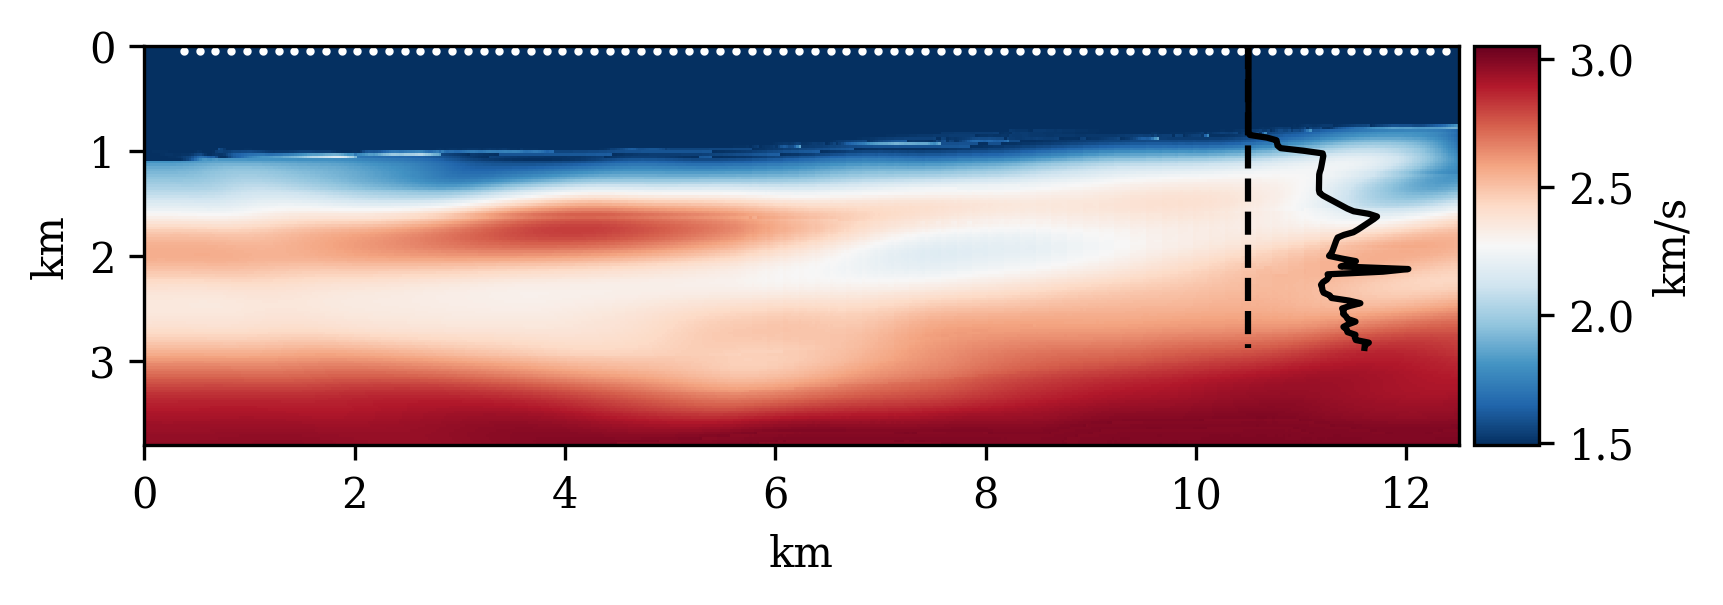

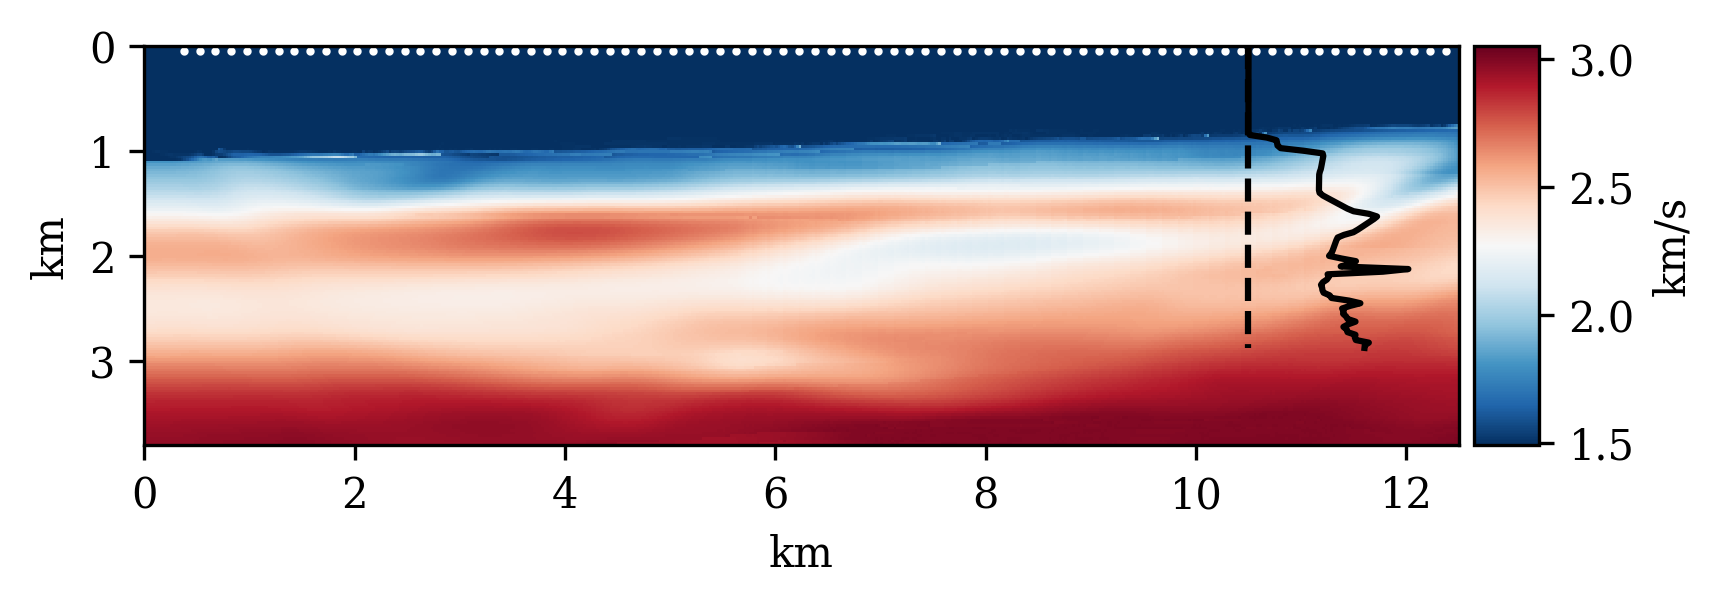

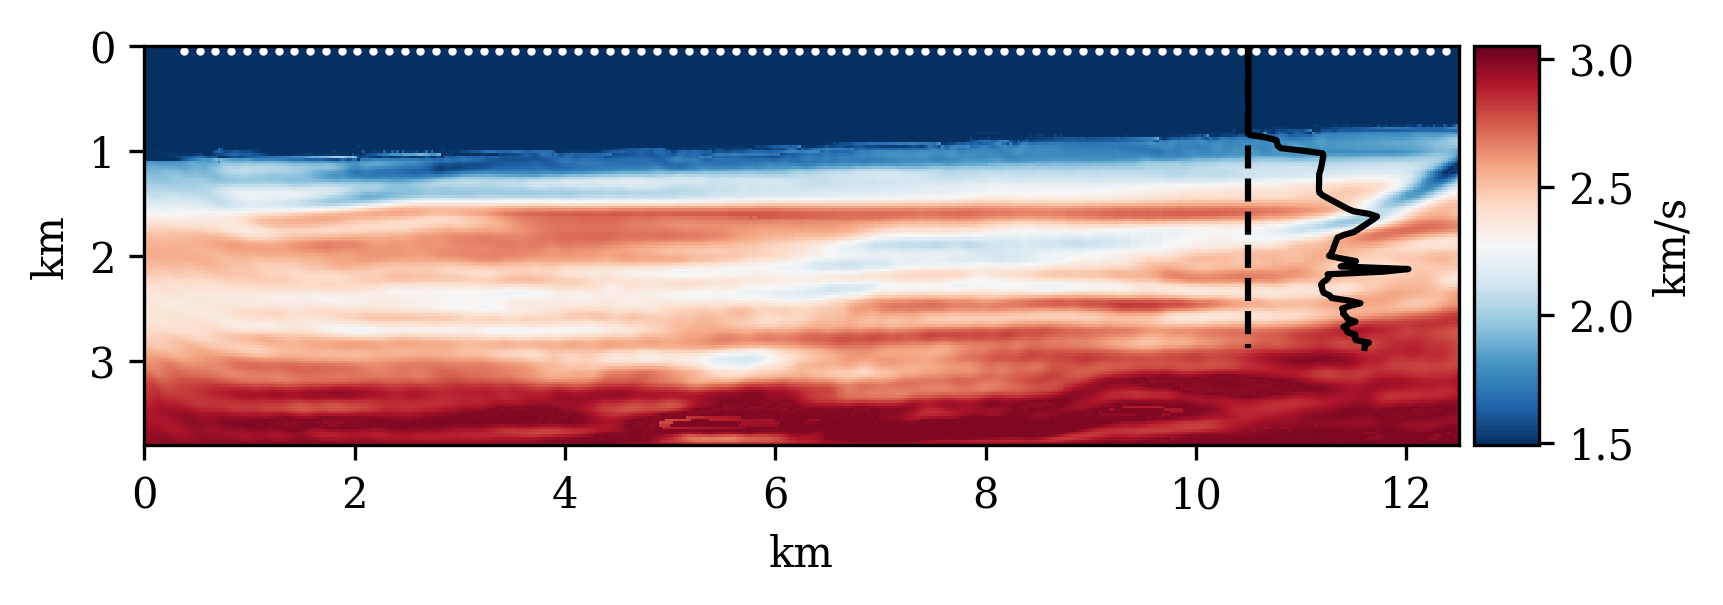

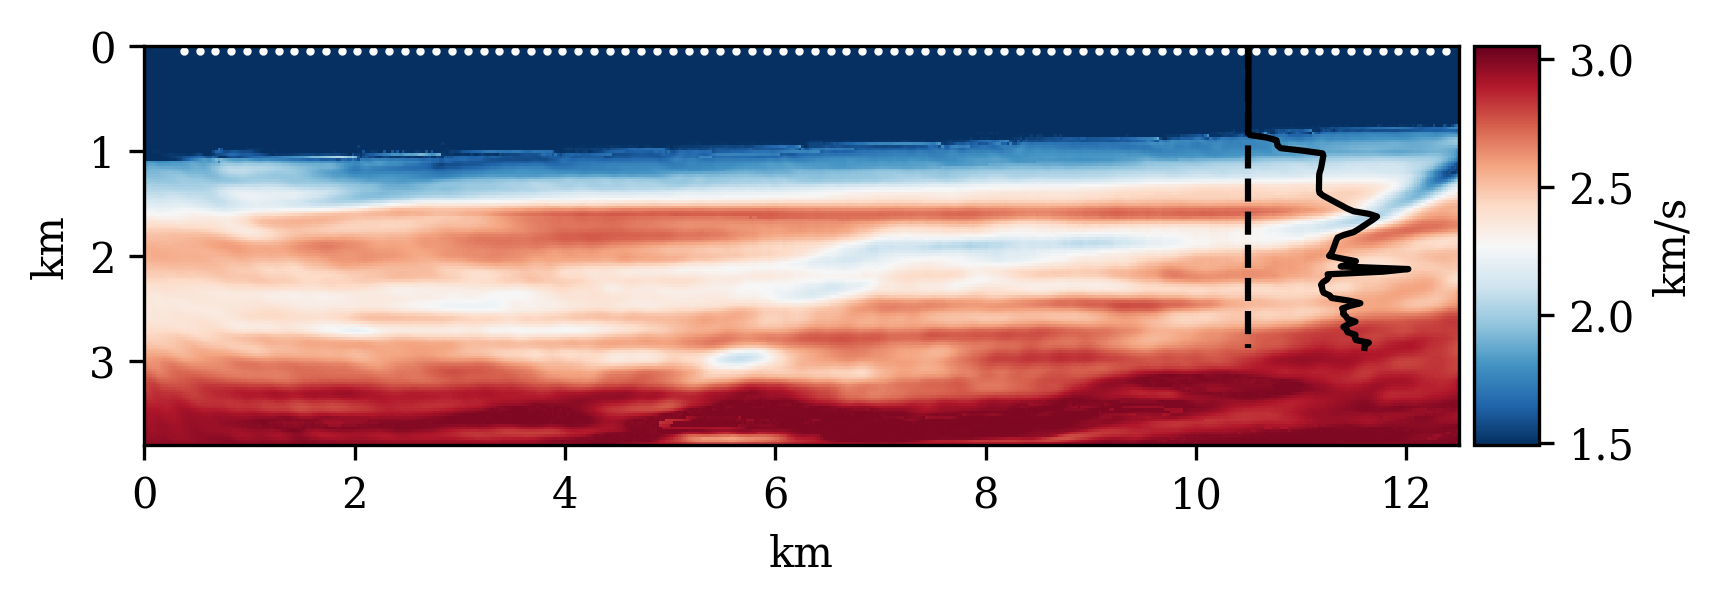

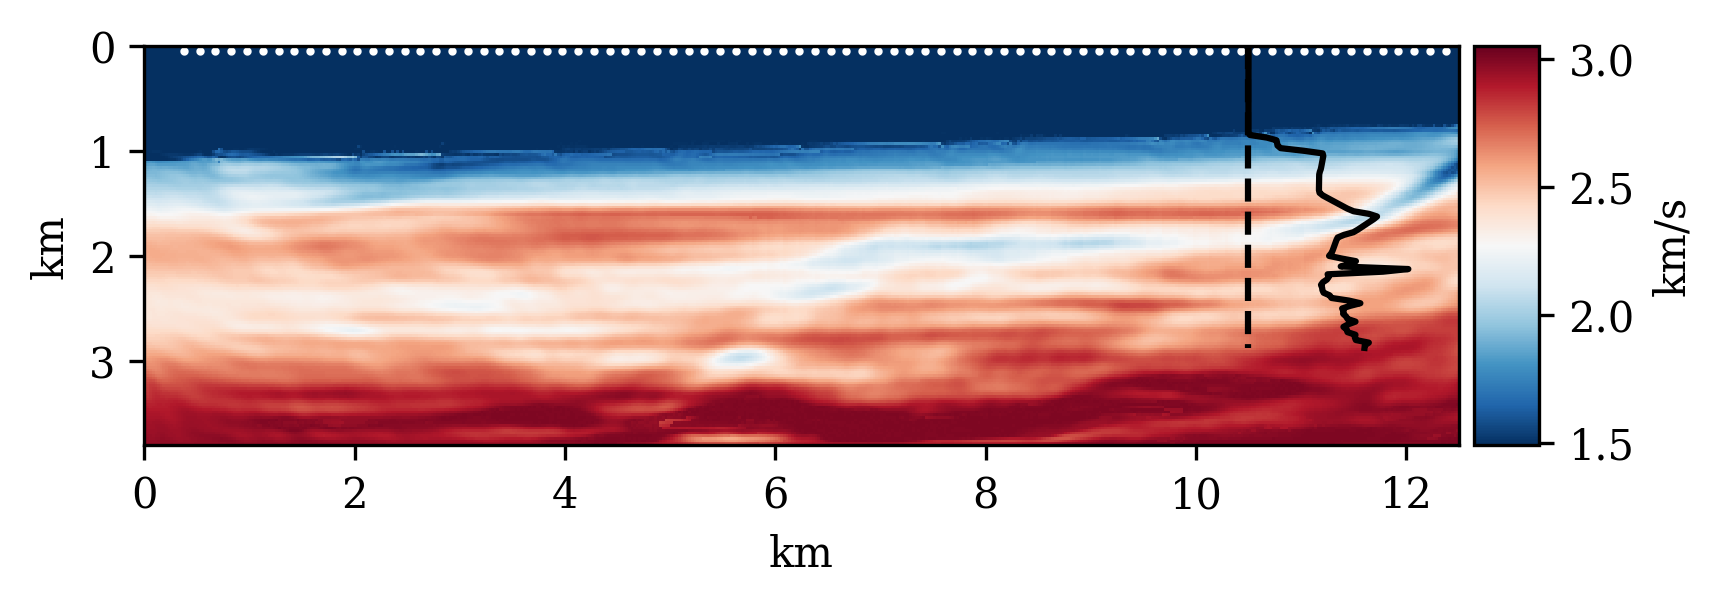

In [106]:
mpl.rcParams['figure.dpi']= 300
models, fnames = d.get_fwi_models(['vp_stage'], return_filenames=True)
for m, f in zip(models, fnames):
    vis.plot_log_model(m, dx, nx0, nz0, src, log=wlog, log_location=log_location, **limits_vp)
mpl.rcParams['figure.dpi']= 100

Read models from ./out_cgg_hard_log6_lpm_extended5/model with ['vp_stage']
< ./out_cgg_hard_log6_lpm_extended5/model/modelTest_vp_stage_1.bin > np.array((672, 152))
< ./out_cgg_hard_log6_lpm_extended5/model/modelTest_vp_stage_2.bin > np.array((672, 152))
< ./out_cgg_hard_log6_lpm_extended5/model/modelTest_vp_stage_3.bin > np.array((672, 152))
< ./out_cgg_hard_log6_lpm_extended5/model/modelTest_vp_stage_4.bin > np.array((672, 152))
< ./out_cgg_hard_log6_lpm_extended5/model/modelTest_vp_stage_5.bin > np.array((672, 152))
Read models from ./out_cgg_hard_log6_lpm_extended5/model with ['vs_stage']
< ./out_cgg_hard_log6_lpm_extended5/model/modelTest_vs_stage_1.bin > np.array((672, 152))
< ./out_cgg_hard_log6_lpm_extended5/model/modelTest_vs_stage_2.bin > np.array((672, 152))
< ./out_cgg_hard_log6_lpm_extended5/model/modelTest_vs_stage_3.bin > np.array((672, 152))
< ./out_cgg_hard_log6_lpm_extended5/model/modelTest_vs_stage_4.bin > np.array((672, 152))
< ./out_cgg_hard_log6_lpm_extended5/mode

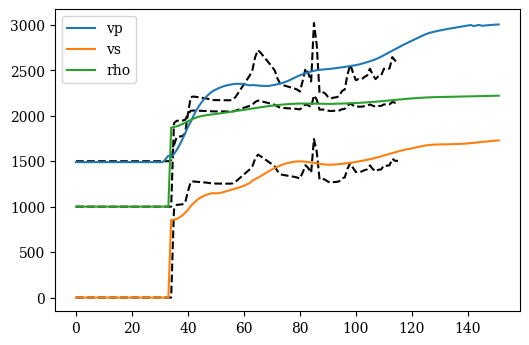

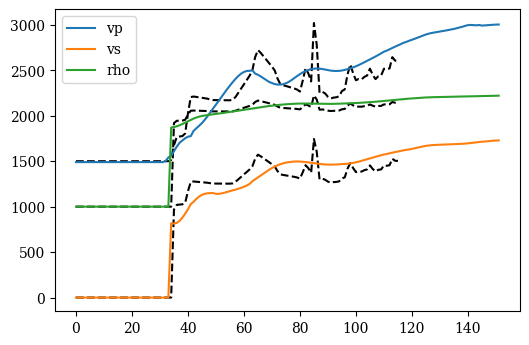

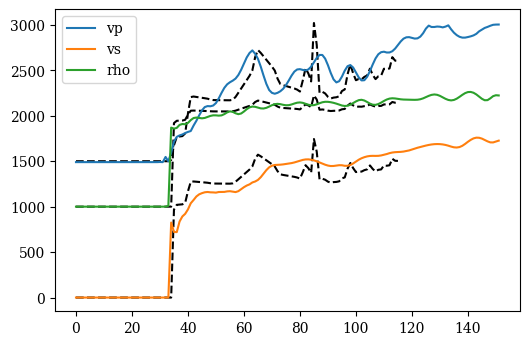

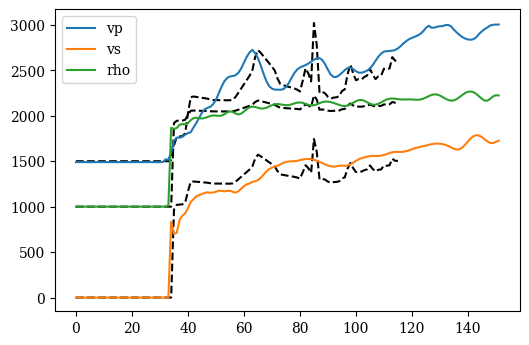

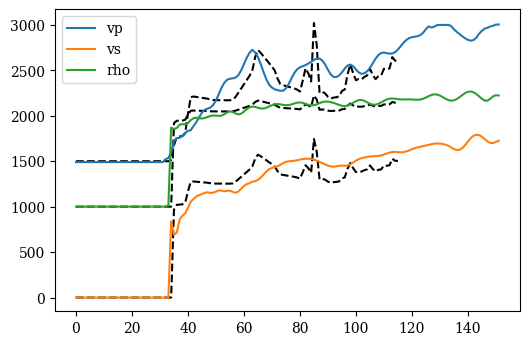

In [107]:
# Load inverted models from all stages
vvr = {'vp': None, 'vs': None, 'rho': None}
for k in vvr.keys():
    vvr[k], fnames = d.get_fwi_models([k + '_stage'], return_filenames=True)

for i in range(len(vvr['vp'])):
    plot_logs(model_log, api.Model(vvr['vp'][i], vvr['vs'][i], vvr['rho'][i], dx), log_idx)

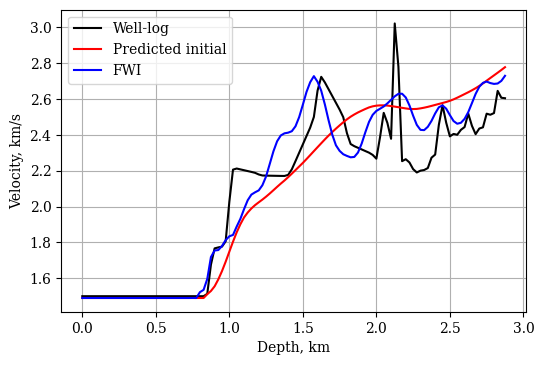

In [108]:
fig, ax = plt.subplots(1,1); 
ax_depth = np.arange(len(wlog)) * dx / 1000
# ax_depth = np.arange(len(log_linear)) * dx / 1000
ax.plot(ax_depth, wlog[::-1] / 1000, 'k', label='Well-log')

log_pred = model_init.vp[-len(log):, log_idx]
ax.plot(ax_depth, log_pred[::-1] / 1000, 'r', label='Predicted initial')

log_inv = vvr['vp'][-1][-len(log):, log_idx]
ax.plot(ax_depth, log_inv[::-1] / 1000, 'b', label='FWI')

ax.set_ylabel('Velocity, km/s')
ax.set_xlabel('Depth, km')
ax.grid(True)
ax.legend()

# Gridspec

In [109]:
# fig10 = plt.figure(constrained_layout=True)
# gs0 = fig10.add_gridspec(1, 1)

# gs00 = gs0[0].subgridspec(2, 3)
# # gs01 = gs0[1].subgridspec(1, 2)

# fig10.add_subplot(gs00[0, 0])
# ax = plt.gca()
# vis.plot_log_model(model_init.vp, dx, nx0, nz0, src, fig_ax=(fig10, ax), axis=None, **limits_vp)

# fig10.add_subplot(gs00[0, 1])
# ax = plt.gca()
# vis.plot_log_model(m, dx, nx0, nz0, fig_ax=(fig10, ax), axis=None, **limits_vp)

# fig10.add_subplot(gs00[0, 2])
# ax = plt.gca()
# vis.plot_log_model(m, dx, nx0, nz0, fig_ax=(fig10, ax), axis=None, **limits_vp)

# fig10.add_subplot(gs00[1, 0])
# ax = plt.gca()
# vis.plot_log_model(m, dx, nx0, nz0, fig_ax=(fig10, ax),**limits_vp)

# fig10.add_subplot(gs00[1, 1])
# ax = plt.gca()
# vis.plot_log_model(m, dx, nx0, nz0, fig_ax=(fig10, ax), axis=None, **limits_vp)

# fig10.add_subplot(gs00[1, 2])
# ax = plt.gca()
# vis.plot_log_model(m, dx, nx0, nz0, fig_ax=(fig10, ax), axis=None,
#                    log=wlog, log_location=log_location, **limits_vp)

# # fig10.add_subplot(gs01[0, 0])
# # fig10.add_subplot(gs01[0, 1])

In [110]:
# d.verbose = 0
# grads, fnames = d.get_fwi_gradients(return_filenames=True)
# for g, f in zip(grads, fnames):
#     plot_model(g, f)

# FWI on field data

In [111]:
# model_last = get_model_last()
# model_last = model_init

In [112]:
# d.DATA_DIR = f'{root_fwi}su/field/seis'
# # d.DATA_DIR = f'{root_fwi}su/pred/seis'
# print(f'Target data: {d.DATA_DIR}')

In [113]:
# par_stages_fwi = {'inv_vs_iter': 0,
#                  'inv_rho_iter': 0,
#                  'normalize': 2,
#                  'order': 6,
#                  }

# d.fwi_stages = []
# freqs_high = [7, 8]
# spatfilters=[4, 0]
# grad_smoothing = [0, 0]
# for i, freq in enumerate(freqs_high):
#     d.add_fwi_stage(fc_high=freq, 
#                     fc_low=5.0,
#                     spatfilter=spatfilters[i],
#                     wd_damp=grad_smoothing[i],
#                     wd_damp1=grad_smoothing[i] / 2,
#                     **par_stages_fwi)
#     print(f'Stage {i+1}:\n\t{d.fwi_stages[i]}\n')

In [114]:
# d.verbose = 0
# d.fwi(model_last, src, rec, **par_fwi_runtime)

In [115]:
# mpl.rcParams['figure.dpi']= 300
# d.set_model(model_init)
# d.save_folder = root_fwi
# d.verbose = 1
# models, fnames_models = d.get_fwi_models(['vp', 'stage'], return_filenames=True)
# for m, f in zip(models, fnames_models):
#     vis.plot_log_model(m, dx, nx0, nz0, src, log=wlog, log_location=log_location, **limits_vp)
# mpl.rcParams['figure.dpi']= 100

In [131]:
# # Load inverted models from all stages
# vvr = {'vp': None, 'vs': None, 'rho': None}
# for k in vvr.keys():
#     vvr[k], fnames = d.get_fwi_models([k + '_stage'], return_filenames=True)

# for i in range(len(vvr['vp'])):
#     plot_logs(model_log, api.Model(vvr['vp'][i], vvr['vs'][i], vvr['rho'][i], dx), log_idx)

# Compare wavefiedls before/after

In [132]:
vps, fnames = d.get_fwi_models(['vp_stage'], return_filenames=True)
vss, fnames = d.get_fwi_models(['vs_stage'], return_filenames=True)
rhos, fnames = d.get_fwi_models(['rho_stage'], return_filenames=True)

if vps:
    model_last = api.Model(vps[-1], vss[-1], rhos[-1], dx)
    print(f'Found last model at {fnames[-1]}')
else:
    print(f'Not found the inverted model in {d.save_folder}!')

Read models from ./out_cgg_hard_log6_lpm_extended5/model with ['vp_stage']
< ./out_cgg_hard_log6_lpm_extended5/model/modelTest_vp_stage_1.bin > np.array((672, 152))
< ./out_cgg_hard_log6_lpm_extended5/model/modelTest_vp_stage_2.bin > np.array((672, 152))
< ./out_cgg_hard_log6_lpm_extended5/model/modelTest_vp_stage_3.bin > np.array((672, 152))
< ./out_cgg_hard_log6_lpm_extended5/model/modelTest_vp_stage_4.bin > np.array((672, 152))
< ./out_cgg_hard_log6_lpm_extended5/model/modelTest_vp_stage_5.bin > np.array((672, 152))
Read models from ./out_cgg_hard_log6_lpm_extended5/model with ['vs_stage']
< ./out_cgg_hard_log6_lpm_extended5/model/modelTest_vs_stage_1.bin > np.array((672, 152))
< ./out_cgg_hard_log6_lpm_extended5/model/modelTest_vs_stage_2.bin > np.array((672, 152))
< ./out_cgg_hard_log6_lpm_extended5/model/modelTest_vs_stage_3.bin > np.array((672, 152))
< ./out_cgg_hard_log6_lpm_extended5/model/modelTest_vs_stage_4.bin > np.array((672, 152))
< ./out_cgg_hard_log6_lpm_extended5/mode

In [133]:
d.save_folder = root_fwi[:-1] + '_wavefield/'
print(f'{root_fwi[:-1]} --> {d.save_folder}')

./out_cgg_hard_log6_lpm_extended5 --> ./out_cgg_hard_log6_lpm_extended5_wavefield/


In [134]:
print(par_forward)

{'run_command': 'mpirun -np 40', 'disable': False}


In [ ]:
d.NPROCX = 1
d.NPROCY = 1
d.forward(model_last, src, rec, **par_forward)

Current directory is /home/ovcharoo/work/nb12_pearson
Init paths at ./out_cgg_hard_log6_lpm_extended5_wavefield/
Init model:
	152 x 672, dx = 25.0 m
Check max source frequency:
	min Vs: 485.1778564453125 m/s
	min Vp: 1490.0 m/s
	Number of gridpoints per minimum wavelength = 3.69
	Maximum source wavelet frequency = 5.259380557672764 Hz
Check domain decomposition for parallelization:
	in X-direction, NX % NPROCX, 672 % 1 = 0
	in Y-direction, NY % NPROCY, 152 % 1 = 0
Write ./out_cgg_hard_log6_lpm_extended5_wavefield/start/model.vp
Write ./out_cgg_hard_log6_lpm_extended5_wavefield/start/model.vs
Write ./out_cgg_hard_log6_lpm_extended5_wavefield/start/model.rho
Custom taper from taper.bin (vp), taper_u.bin (vs) and taper_rho.bin (rho)
Enable streamer mode!
	source 1: ./out_cgg_hard_log6_lpm_extended5_wavefield/receiver/receivers_shot_1
	source 2: ./out_cgg_hard_log6_lpm_extended5_wavefield/receiver/receivers_shot_2
	source 3: ./out_cgg_hard_log6_lpm_extended5_wavefield/receiver/receivers_sh

	wavelet 20: ./out_cgg_hard_log6_lpm_extended5_wavefield/wavelet/wavelet_shot_20.dat
	wavelet 21: ./out_cgg_hard_log6_lpm_extended5_wavefield/wavelet/wavelet_shot_21.dat
	wavelet 22: ./out_cgg_hard_log6_lpm_extended5_wavefield/wavelet/wavelet_shot_22.dat
	wavelet 23: ./out_cgg_hard_log6_lpm_extended5_wavefield/wavelet/wavelet_shot_23.dat
	wavelet 24: ./out_cgg_hard_log6_lpm_extended5_wavefield/wavelet/wavelet_shot_24.dat
	wavelet 25: ./out_cgg_hard_log6_lpm_extended5_wavefield/wavelet/wavelet_shot_25.dat
	wavelet 26: ./out_cgg_hard_log6_lpm_extended5_wavefield/wavelet/wavelet_shot_26.dat
	wavelet 27: ./out_cgg_hard_log6_lpm_extended5_wavefield/wavelet/wavelet_shot_27.dat
	wavelet 28: ./out_cgg_hard_log6_lpm_extended5_wavefield/wavelet/wavelet_shot_28.dat
	wavelet 29: ./out_cgg_hard_log6_lpm_extended5_wavefield/wavelet/wavelet_shot_29.dat
	wavelet 30: ./out_cgg_hard_log6_lpm_extended5_wavefield/wavelet/wavelet_shot_30.dat
	wavelet 31: ./out_cgg_hard_log6_lpm_extended5_wavefield/wavelet/

In [ ]:
# print(d.stdout)

Read 85 shots (324, 3000) into list
Shot 24: 3975.0 m
Shot 51: 8025.0 m


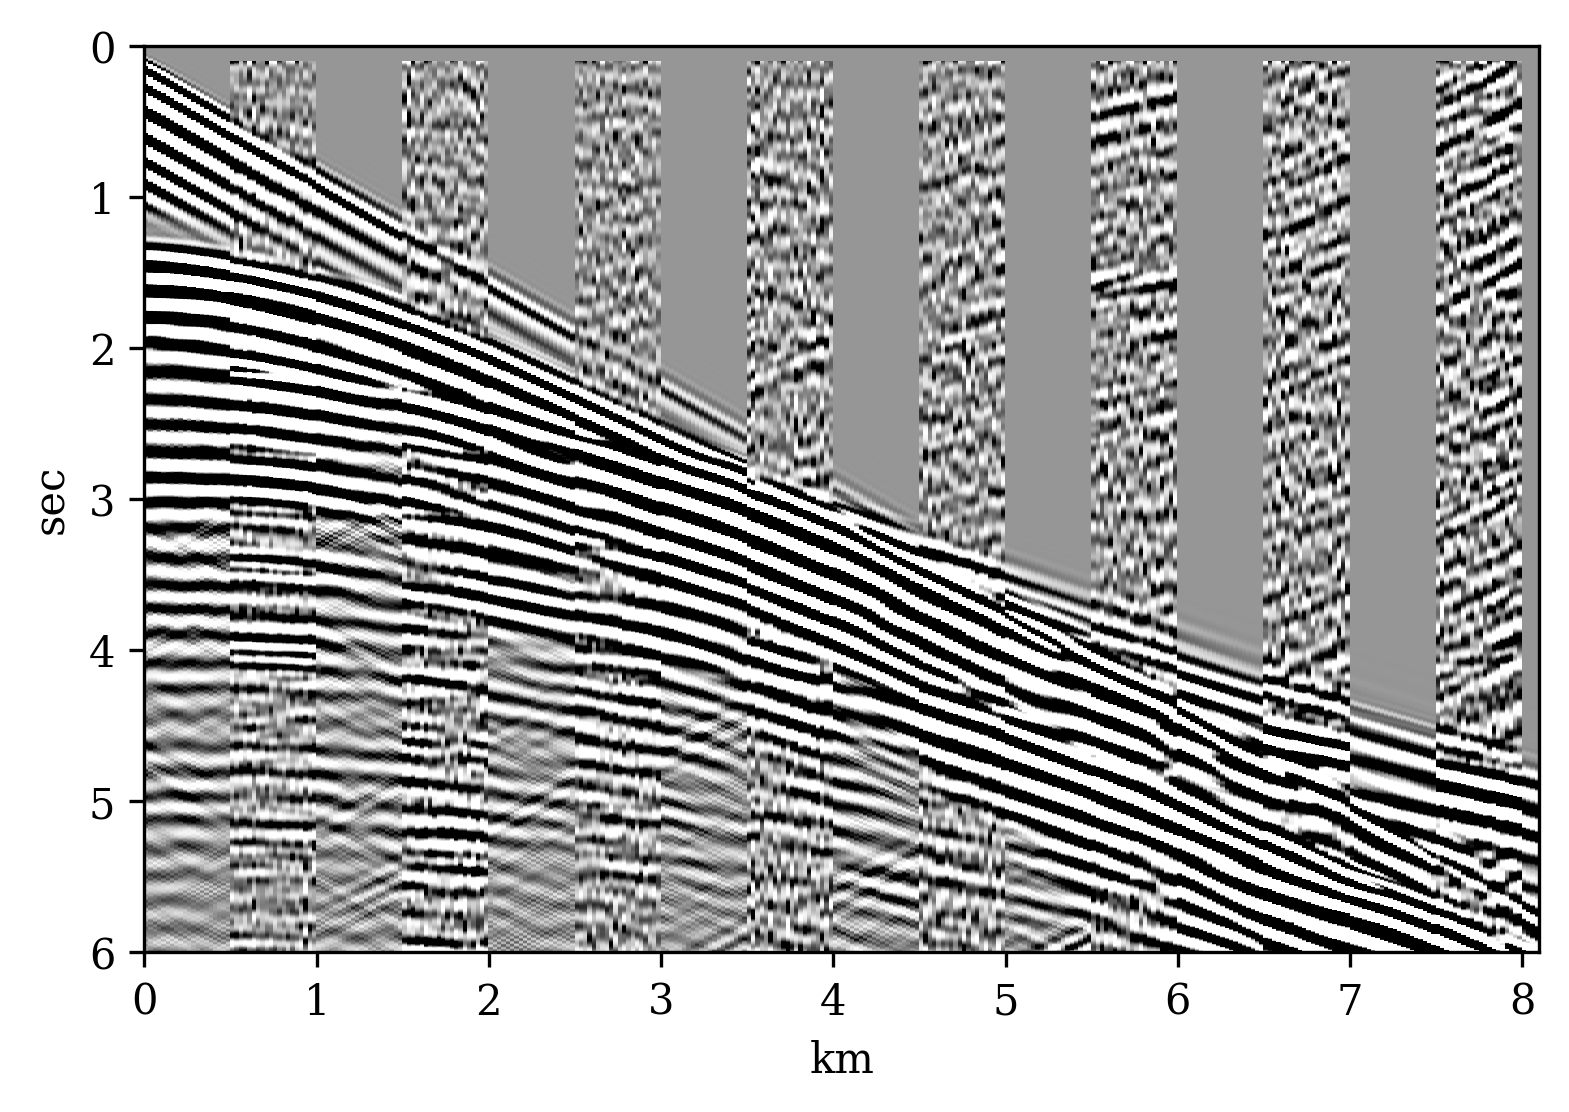

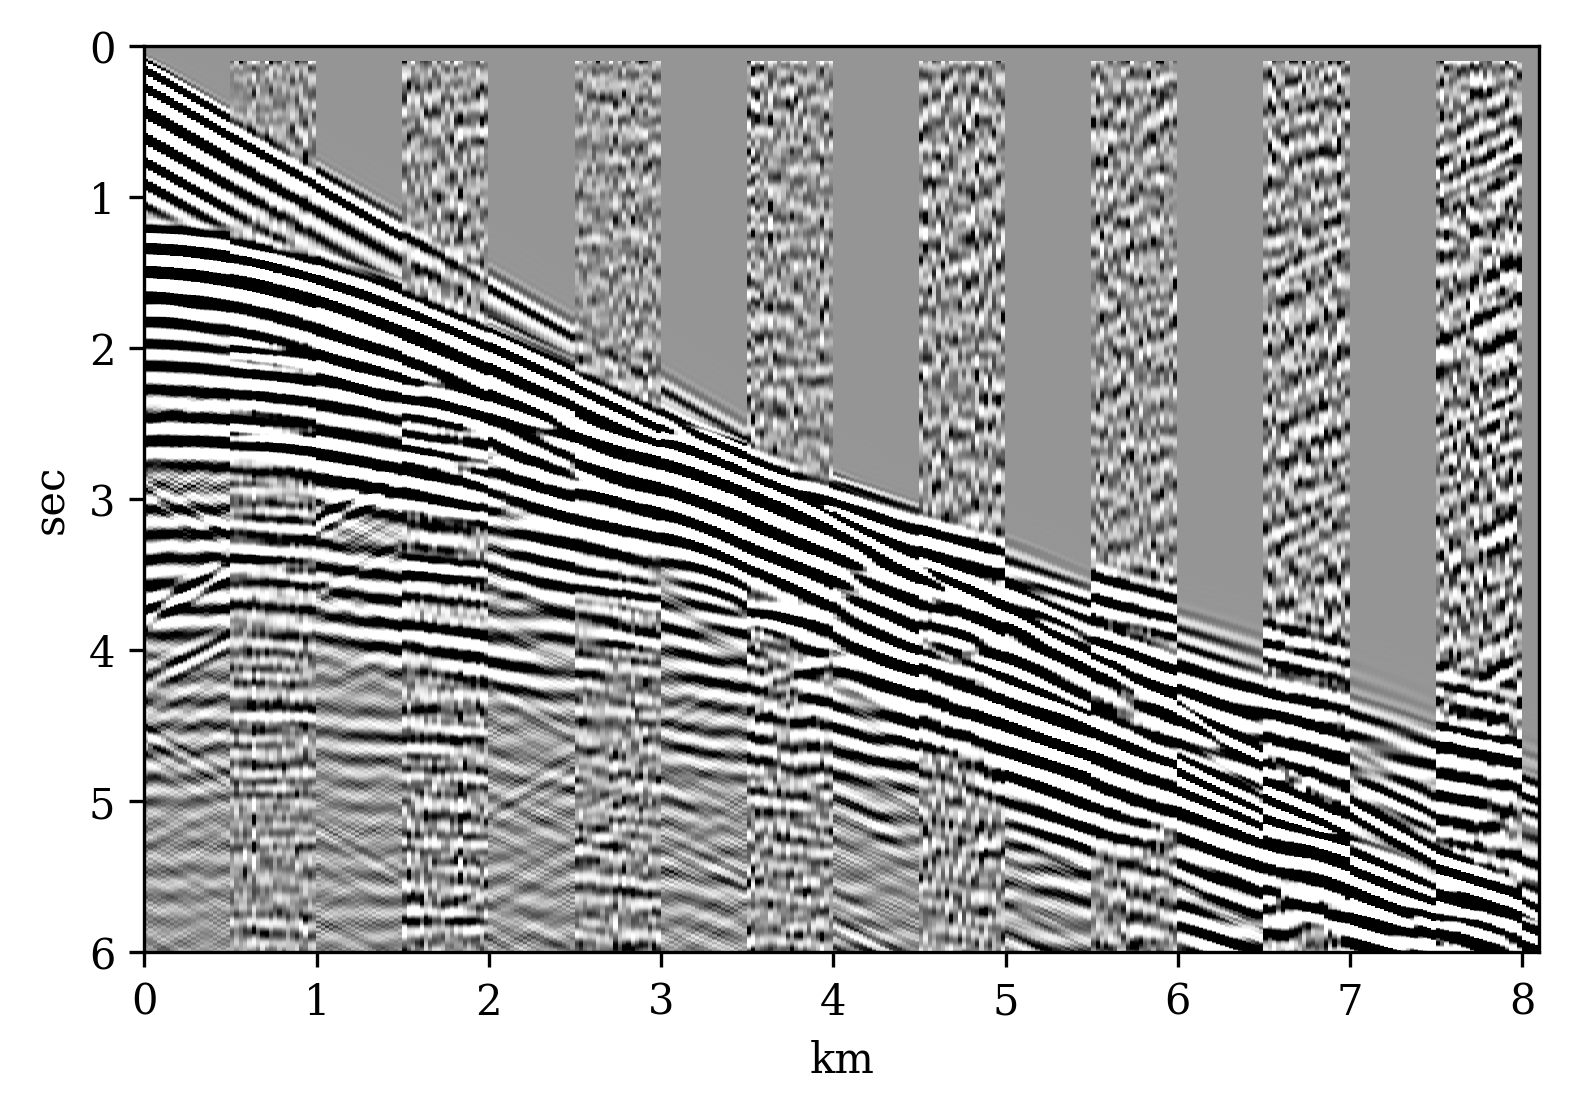

In [188]:
d.verbose = 0    # don't show redundant print outs

if d.DT is None:
    d.DT = 0.002
shots = d.get_shots(keys=['_p'])
# shots = [ld.bandpass(s, fs=1./(d.DT * d.NDT), **par_bp) for s in d.get_shots(keys=['_p'])]
print(f'Read {len(shots)} shots {shots[0].shape} into list')

mpl.rcParams['figure.dpi']= 300
# for ishot in [int(np.floor(x)) for x in np.linspace(0, len(shots)-1, 5)]:
for ishot in selected_shot_ids:
    print(f'Shot {ishot}: {src.x[ishot]} m')
    shot_s = divmax(shots[ishot])
    shot_f = divmax(data_p[ishot, :, ::d.NDT])
#     vis.plot_shot(np.concatenate([np.flip(shot_s, 0), shot_f], axis=0), pclip=0.05)
    vis.plot_compare_stripes(shot_s, shot_f, pclip=0.0125, colorbar=False, dt=d.DT, dx=dx)
mpl.rcParams['figure.dpi']= 100

# Loss curve

opteps epst[1] epst[2] epst[3] L2t[1] L2t[2] L2t[3] L2t[1] FC_low FC_high nstage
(11, 34)


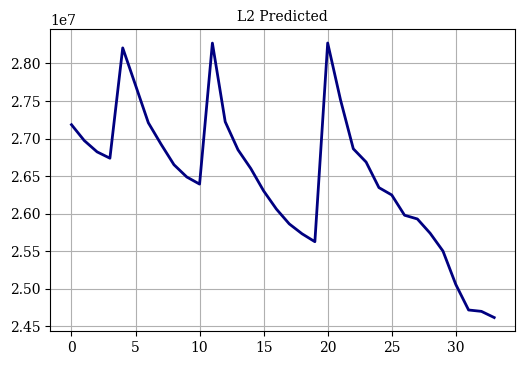

In [42]:
# curve = np.loadtxt(os.path.join(root_fwi, 'seis_fwi_log.dat'), unpack=True)
curve = np.loadtxt(os.path.join('/home/ovcharoo/work/nb12_pearson/out_cgg_hard_log6_lpm_fullband', 'seis_fwi_log.dat'), unpack=True)
print('opteps epst[1] epst[2] epst[3] L2t[1] L2t[2] L2t[3] L2t[1] FC_low FC_high nstage')
print(curve.shape) 
c0 = curve[4, :]
c0 /= curve[-2, :]**2
# c /= np.max(c)
plt.plot(c0, c='navy', lw=2); plt.title('L2 Predicted'); plt.grid('on');

normalize by square of frequency

рассеяное поле по Борну зависит от квадрата частоты

если не нормировать, то амплитуда шума возрастает с частотой и его никогда нельзя зафитить

амплитуда спектра шума с частотой - это покажет сколько шума на каких частотах

Mulder Plessix

opteps epst[1] epst[2] epst[3] L2t[1] L2t[2] L2t[3] L2t[1] FC_low FC_high nstage
(11, 21)


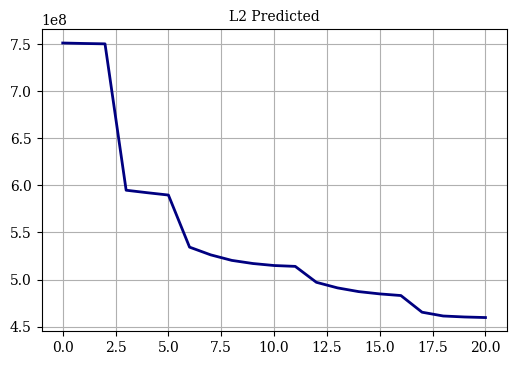

In [43]:
curve = np.loadtxt(os.path.join(root_fwi, 'seis_fwi_log.dat'), unpack=True)
# curve = np.loadtxt(os.path.join('/home/ovcharoo/work/nb12_pearson/out_cgg_hard_log6_lpm_fullband', 'seis_fwi_log.dat'), unpack=True)
print('opteps epst[1] epst[2] epst[3] L2t[1] L2t[2] L2t[3] L2t[1] FC_low FC_high nstage')
print(curve.shape)
c = curve[4, :]
c /= curve[-2, :]**1
# c /= np.max(c)
plt.plot(c, c='navy', lw=2); plt.title('L2 Predicted'); plt.grid('on');
# plt.semilogy(c, c='navy', lw=2); plt.title('L2 Predicted'); plt.grid('on');
# plt.semilogy(c0, 'k--', lw=2)

In [2]:
# test_shot = data_p[0, ...].copy()
# test_shot[-200:, :] = test_shot.min() 
# test_shot[:, :1000] = test_shot.min() 
# vis.plot_shot(test_shot)

NameError: name 'data_p' is not defined

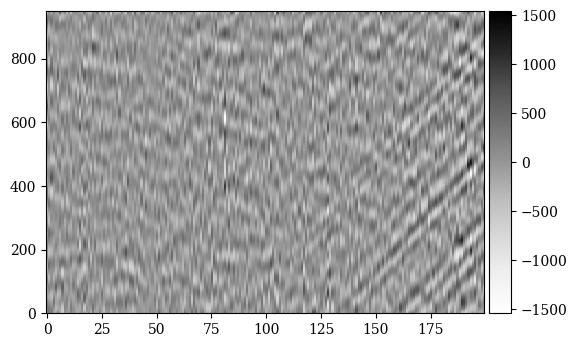

In [45]:
vis.plot_shot(data_p[0, -200:, 50:1000])

[3, 4, 5, 6, 7] [864112413.9594339, 2143269086.7658033, 2749758537.1029925, 2882118404.156946, 2916368377.985511]


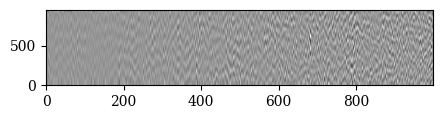

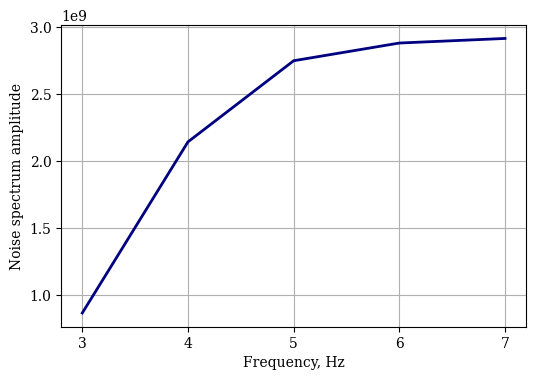

In [68]:
maxes = []
noise_samples = []
for fhi in freqs_high:
#     noise = ld.bandpass(np.mean(data_p[:, ...], 0), fhi=fhi, dt=0.002, btype='low')
    noise = ld.bandpass(data_p[0, -200:, 50:1000], fhi=fhi, dt=0.002, btype='low')
#     vis.plot_shot(noise, dpi=50)
    ff, ss = vis.get_spectrum(noise, dt=0.002, phase=False)
    maxes.append(ss.max())
    noise_samples.append(noise)
    
vis.plot_shot(noise_samples, figsize=(len(noise_samples), 1), colorbar=False, axis=True, dpi=100)

plt.figure();
plt.plot(freqs_high, maxes, c='navy', lw=2); 
print(freqs_high, maxes)
a = plt.gca()
a.set_xticks(freqs_high)
a.set_xticklabels([int(v) for v in freqs_high])

plt.ylabel('Noise spectrum amplitude'); 
plt.grid('on'); plt.xlabel('Frequency, Hz');
#     vis.plot_spectrum(noise, dt=0.002, fmax=10)

In [49]:
norm_maxes = np.array(maxes)
norm_maxes = norm_maxes / np.min(norm_maxes)
print(norm_maxes)

[1.         2.48031281 3.18217687 3.33535123 3.37498725]


# From Kohn

https://github.com/daniel-koehn/DENISE-Black-Edition/blob/master/par/visu/Misfit_step_length_evolution.ipynb

### Read

In [50]:
filename = os.path.join(root_fwi, 'seis_fwi_log.dat')
data = np.genfromtxt(filename)

# estimate number of iterations
nit, npara = np.shape(data)
iteration = np.linspace(1,nit,nit,dtype=int)

# estimate number of stages
tmp = np.max(data[:,10])
nstage = tmp.astype(int)

# estimate number of iterations / FWI stage
niter_stage = np.zeros(nstage, dtype=int)

h=1
stage = 1
for i in range(1, nit):
    
    if data[i,10] == stage:
        h = h + 1
        
    if data[i,10] != stage:
        niter_stage[stage-1] = h - 1
        h = 1
        stage = stage + 1
        
    if i == (nit-1):
        niter_stage[stage-1] = h - 1

# define iteration number for transition from one stage to the next
nstage_trans = np.cumsum(niter_stage)

noise_scalers = data[:, 4].copy()
for iun, un in enumerate(np.unique(data[:, -2])):
    noise_scalers[data[:, -2] == un] = norm_maxes[iun]
# print(noise_scalers)

# normalize misfit function to maximum value
data[:, 4] = data[:, 4] / data[:, -2] ** 1
# data[:, 4] = data[:, 4] / noise_scalers
data[:, 4] = data[:,4] / np.max(data[:,4])
print(len(data[:, 4]))

21


### Init fonts

In [51]:
# FSize = 20
# font = {'color':  'black',
#         'weight': 'normal',
#         'size': FSize}
# mpl.rc('xtick', labelsize=FSize) 
# mpl.rc('ytick', labelsize=FSize) 
# mpl.rcParams['figure.figsize'] = 12, 11
# mpl.rc('font',**{'family':'sans-serif','sans-serif':['Helvetica']})
# mpl.rc('text', usetex=True)

### Plot

<ipython-input-61-5d6c1871a3ca>:11: UserWarning: FixedFormatter should only be used together with FixedLocator
  a.set_xticklabels([int(v) for v in a.get_xticks()])


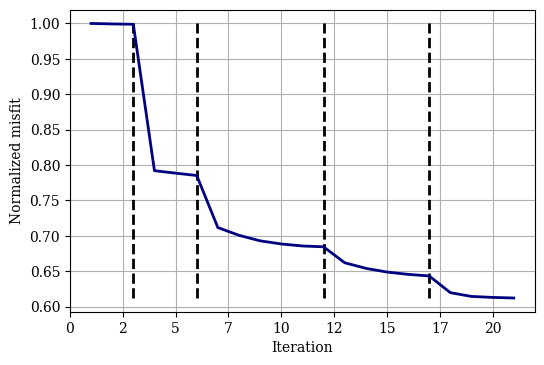

In [61]:
def plot_misfit(data):
    # plot stage boundaries
    for i in range(1, nstage):
        plt.plot([nstage_trans[i-1]+i,nstage_trans[i-1]+i], [np.min(data[:,4]),np.max(data[:,4])],'k--', linewidth=2)

    # plot misfit function
    plt.plot(iteration, data[:,4], color='navy', linewidth=2, label='Evolution of the misfit function')

    # scale and annotate axis
    a = plt.gca()
    a.set_xticklabels([int(v) for v in a.get_xticks()])
    # a.set_yticklabels(a.get_yticks(), font)
    plt.ylabel('Normalized misfit'# function'#, fontdict=font
              )
    plt.xlabel('Iteration'#, fontdict=font
              )
    # plt.autoscale(enable=True, axis='y', tight=True)

    # # add FWI stages and iteration numbers per stage 
    # for i in range(1, nstage+1):
    #     stage_title = "stage" + "%0.*f" %(0,np.fix(i)) + "\n (" + "%0.*f" %(0,np.fix(niter_stage[i-1])) + " iterations)"
    #     plt.text(nstage_trans[i-1] - 0.85 * niter_stage[i-1], 0.6, stage_title, fontdict=font, color='black')

    # plt.tight_layout()

    # figure output
    #plt.savefig('test.png', format='png', dpi=100)
    # plt.savefig('misfit.pdf', bbox_inches='tight', format='pdf')
#     plt.show()
    plt.grid('on')
    
plot_misfit(data)

### Plot step length estimation

<ipython-input-62-830805f19dae>:10: UserWarning: FixedFormatter should only be used together with FixedLocator
  a.set_xticklabels([int(v) for v in a.get_xticks()])


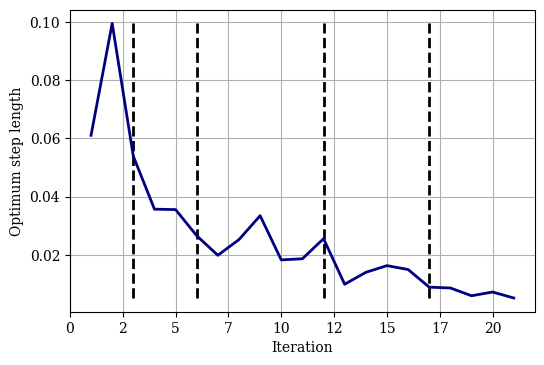

In [62]:
# plot stage boundaries
for i in range(1, nstage):
    plt.plot([nstage_trans[i-1]+i,nstage_trans[i-1]+i], [np.min(data[:,0]),np.max(data[:,0])],'k--', linewidth=2)

# plot misfit function
plt.plot(iteration,data[:,0], color='navy', linewidth=2)

# scale and annotate axis
a = plt.gca()
a.set_xticklabels([int(v) for v in a.get_xticks()])
# a.set_yticklabels(a.get_yticks(), font)
plt.ylabel('Optimum step length'#from parabolic line search'#, fontdict=font
          )
plt.xlabel('Iteration'#, fontdict=font
          )
# plt.autoscale(enable=True, axis='y', tight=True)

# add FWI stages and iteration numbers per stage 
# for i in range(1, nstage+1):
#     stage_title = "Stage " + "%0.*f" %(0,np.fix(i)) + "\n (" + "%0.*f" %(0,np.fix(niter_stage[i-1])) + " iterations)"
#     plt.text(nstage_trans[i-1] - 0.85 * niter_stage[i-1], np.max(data[:,0]) - 0.4 * np.max(data[:,0]), stage_title, fontdict=font, color='black')

# plt.tight_layout()

# figure output
#plt.savefig('test.png', format='png', dpi=100)
# plt.savefig('opt_step_length.pdf', bbox_inches='tight', format='pdf')
# plt.show()
plt.grid('on')